---

#  Large Language Models

Vấn đề đầu tiên là khởi tạo 1 dataset sinh từ AI model có sẵn

-> call API của Deepseek cho rẻ


sk-4e91596cb0a8447c842d2dc8314d2e2aa




In [ ]:
!pip install requests tqdm

---
Ý tưởng ban đầu call API, tạo 400.000 bình luận

tuy nhiên vấn đề xảy ra đầu tiên, mỗi lần tạo lại chắc chắc sẽ có khả năng TRÙNG LẶP

-->

1.Sử dụng set() để loại bỏ bình luận trùng khi ghi vào CSV.

2.Gửi prompt yêu cầu tạo bình luận mới, tránh lặp lại.

3.Chặn bình luận trùng trước khi ghi vào file CSV.

---

# 0. BƯỚC TẠO DATASET

In [ ]:
import requests
import json
import csv
import time
import re
from tqdm import tqdm

In [ ]:
#API key
API_KEY = "sk-fccb870d44d64247a4a83e7a57a1b887" #+1
API_URL = "https://api.deepseek.com/chat/completions"

// Vì API deepseek trả về json, nên phải lấy định dạng này đâu tiên rồi mới lưu vào file .csv

'''
    #Mẫu yêu cầu API (Prompt)
    PROMPT_TEMPLATE = """
    Hãy tạo một bình luận về bài hát "There's No One At All" của Sơn Tùng M-TP với nhãn cảm xúc:
    - "Positive" nếu bình luận tích cực.
    - "Negative" nếu bình luận tiêu cực.
    - "Neutral" nếu bình luận trung lập.

    Trả lời dưới dạng JSON với format:
    {
        "comment": "Nội dung bình luận",
        "label": "Positive" hoặc "Negative" hoặc "Neutral"
    }
    """

    #Tệp CSV đầu ra
    OUTPUT_FILE = "son_tung_comments.csv"

    #Danh sách bình luận để tránh trùng lặp
    unique_comments = set()
'''

Vấn đề xảy ra là bị lặp như máy móc quá:

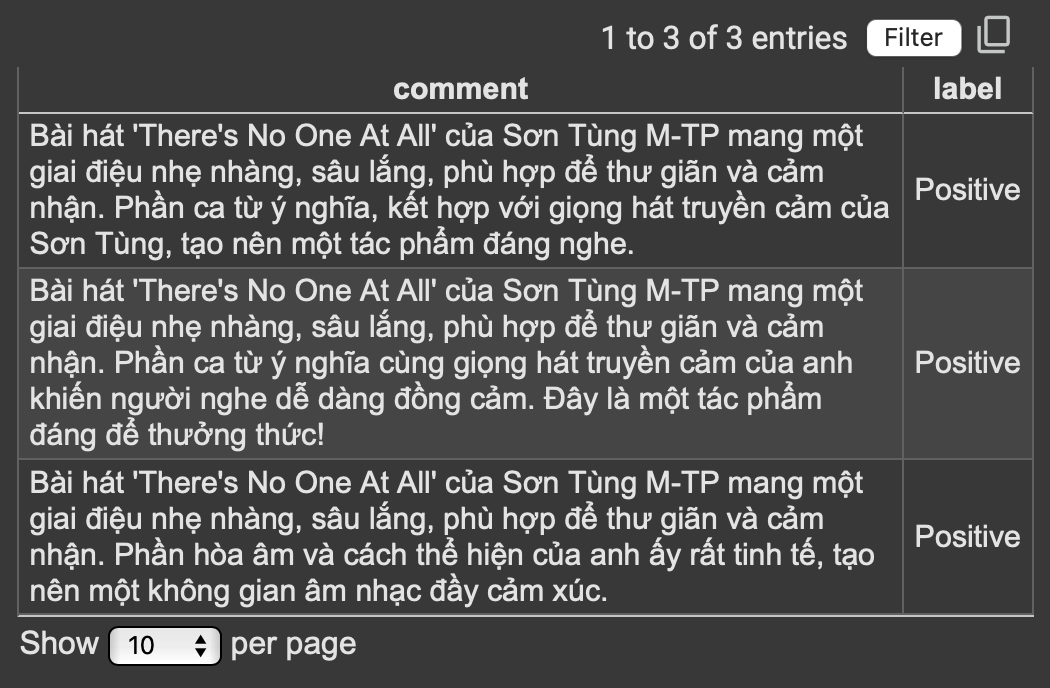

Giải pháp là đây:

---

In [ ]:
import random

In [ ]:
PROMPT_VARIATIONS = [
    "Chia sẻ cảm xúc của bạn về bài hát vừa nghe một cách tự nhiên như trên Facebook hoặc YouTube.",
    "Bình luận một cách hài hước hoặc chân thực về ca khúc bạn vừa nghe.",
    "Hãy để lại một bình luận ngắn gọn và tự nhiên về bộ phim bạn vừa xem.",
    "Bình luận như một fan hâm mộ cuồng nhiệt hoặc một người xem trung lập về trận đấu thể thao vừa diễn ra.",
    "Viết một bình luận bày tỏ sự hài lòng hoặc thất vọng về sản phẩm công nghệ mới nhất bạn vừa mua.",
    "Chia sẻ cảm nhận về chuyến du lịch hoặc nhà hàng bạn vừa trải nghiệm theo cách thú vị.",
    "Bình luận như một game thủ thực thụ về trải nghiệm chơi game mới nhất của bạn.",
    "Hãy viết một nhận xét ngắn về cuốn sách hoặc bộ truyện bạn vừa đọc.",
    "Bình luận như một người thực sự tham gia sự kiện thay vì một câu nhận xét cứng nhắc.",
    "Tưởng tượng bạn đang nói chuyện với bạn bè trên mạng xã hội, hãy viết một bình luận thật tự nhiên.",

    #sở thích
    "Bạn vừa nghe một bài hát, hãy để lại một bình luận tự nhiên như trên Facebook hoặc YouTube.",
    "Hãy viết một bình luận thật chân thực như một người hâm mộ hoặc một người nghe bình thường về một ca khúc.",
    "Bạn vừa chơi xong một game, hãy để lại bình luận về trải nghiệm của bạn.",
    "Bạn vừa xem một bộ phim, hãy để lại một bình luận về nó.",
    "Bạn vừa xem một trận đấu thể thao, hãy viết bình luận về màn trình diễn của đội hoặc vận động viên bạn yêu thích.",
    "Bạn vừa mua một sản phẩm công nghệ mới, hãy để lại đánh giá về nó.",

    # Chủ đề tranh luận
    "Phương tiện truyền thông xã hội có gây hại cho xã hội nhiều hơn lợi ích không?",
    "Bạn có nghĩ rằng cần sa nên được hợp pháp hóa cho mục đích giải trí không?",
    "Đại học có nên được cung cấp miễn phí không?",
    "Trường học có nên dạy giáo dục giới tính toàn diện không?",
    "Có đạo đức khi sử dụng động vật cho nghiên cứu khoa học không?",
    "Hoạt động của con người có phải là nguyên nhân chính của biến đổi khí hậu không?",
    "Có nên dừng tổ chức các cuộc thi hoa hậu không?",
    "Thẻ tín dụng có làm hại nhiều hơn lợi không?",
    "Có nên cấm hoàn toàn thuốc giảm cân không?",
    "Nhân bản con người có nên được cho phép không?",
    "Có nên có luật chặt chẽ hơn về quyền sở hữu súng không?",
    "Biến đổi khí hậu có thực sự nghiêm trọng hay bị phóng đại?",
    "Cá nhân có quyền tự kết thúc cuộc sống của mình trong một số trường hợp không?",
    "Có nên kiểm duyệt hoặc hạn chế một số loại bài phát biểu không?",
    "Ăn thịt động vật có phi đạo đức không?",
    "Có nên có những quy định chặt chẽ hơn về nhập cư và tị nạn không?",
    "An ninh công việc có quan trọng hơn tiền không?",
    "Sở thú có gây hại nhiều hơn lợi ích không?",
    "Cha mẹ có nên chịu trách nhiệm pháp lý về hành động của con cái họ không?",
    "Áp lực ngang hàng có ảnh hưởng tích cực hay tiêu cực không?",

    "Bạn vừa nghe một bài hát, hãy để lại một bình luận tự nhiên như trên Facebook hoặc YouTube.",
    "Hãy viết một bình luận thật chân thực như một người hâm mộ hoặc một người nghe bình thường về một ca khúc.",
    "Bạn vừa chơi xong một game, hãy để lại bình luận về trải nghiệm của bạn.",
    "Bạn vừa xem một bộ phim, hãy để lại một bình luận về nó.",
    "Bạn vừa xem một trận đấu thể thao, hãy viết bình luận về màn trình diễn của đội hoặc vận động viên bạn yêu thích.",
    "Bạn vừa mua một sản phẩm công nghệ mới, hãy để lại đánh giá về nó.",
    "Bạn vừa thử một món ăn mới hoặc đến một nhà hàng, hãy để lại bình luận về trải nghiệm của bạn.",
    "Bạn vừa đọc xong một cuốn sách hoặc bộ truyện tranh, hãy để lại nhận xét của bạn.",
    "Bạn vừa ghé thăm một địa điểm du lịch, hãy chia sẻ cảm nhận của mình.",
    "Bạn vừa mua một món đồ thời trang mới, hãy để lại đánh giá của bạn.",
    "Bạn vừa tham gia một sự kiện hoặc buổi hòa nhạc, hãy để lại bình luận về trải nghiệm của bạn.",
    "Bạn vừa cài đặt một ứng dụng hoặc thử một dịch vụ trực tuyến, hãy chia sẻ đánh giá của bạn.",
    "Bạn vừa sử dụng dịch vụ xe công nghệ hoặc thử một mẫu xe mới, hãy để lại nhận xét của bạn.",
    "Bạn vừa tham gia một khóa học hoặc sự kiện giáo dục, hãy chia sẻ cảm nhận của mình.",
    "Bạn vừa tham gia một cuộc thi hoặc sự kiện thể thao, hãy viết bình luận về trải nghiệm của bạn.",
    "Bạn vừa tham gia một sự kiện chính trị hoặc xã hội, hãy chia sẻ cảm nhận của mình.",
    "Bạn vừa tham gia một sự kiện văn hóa hoặc nghệ thuật, hãy viết bình luận.",
    "Bạn vừa tham gia một sự kiện chuyên ngành (khoa học, công nghệ, y tế, sức khỏe...), hãy chia sẻ cảm nhận của mình.",
    "Bạn vừa tham gia một sự kiện môi trường hoặc bảo vệ động vật, hãy chia sẻ cảm nhận của mình.",
    "Bạn vừa du lịch đến một quốc gia, hãy viết bình luận về chuyến đi của mình.",

    #Chủ đề Giải trí & Trải nghiệm cá nhân
    "Viết một bình luận hài hước hoặc cảm động về bài hát bạn vừa nghe.",
    "Bạn vừa xem một bộ phim bom tấn, hãy chia sẻ cảm nhận của mình một cách tự nhiên.",
    "Hãy bình luận như một người đam mê thể thao về trận đấu vừa diễn ra.",
    "Viết đánh giá của bạn về tựa game mới nhất bạn vừa chơi, hãy bày tỏ cảm xúc thật.",
    "Bạn vừa thử một nhà hàng mới, hãy viết nhận xét về món ăn và không gian.",
    "Viết một bình luận ngắn về cuốn sách hoặc truyện tranh mà bạn vừa đọc.",
    "Hãy chia sẻ một bình luận hài hước về một bộ phim hoặc chương trình truyền hình bạn vừa xem.",
    "Bạn vừa đi du lịch đến một địa điểm tuyệt vời, hãy chia sẻ cảm nhận của mình.",
    "Hãy viết một đánh giá như một tín đồ công nghệ về sản phẩm mới nhất bạn vừa sử dụng.",
    "Chia sẻ suy nghĩ của bạn về một sự kiện âm nhạc hoặc concert mà bạn vừa tham dự.",

    #Chủ đề Đời sống
    "Bạn vừa tham gia một sự kiện cộng đồng hoặc từ thiện, hãy viết một bình luận chia sẻ trải nghiệm.",
    "Chia sẻ cảm nhận của bạn về một bài phát biểu, bài diễn thuyết hoặc hội thảo bạn vừa tham gia.",
    "Bạn vừa thử một ứng dụng hoặc phần mềm mới, hãy để lại đánh giá của mình.",
    "Viết một bình luận bày tỏ sự hài lòng hoặc thất vọng về một dịch vụ bạn vừa trải nghiệm.",
    "Bạn vừa tham gia một khóa học hoặc hội thảo giáo dục, hãy chia sẻ cảm nhận.",
    "Chia sẻ đánh giá của bạn về một xu hướng thời trang hoặc món đồ bạn vừa mua.",
    "Bạn vừa xem một video viral trên mạng xã hội, hãy viết một bình luận về nó.",
    "Bày tỏ quan điểm của bạn về một chủ đề đang gây tranh cãi trên mạng xã hội.",
    "Viết một bình luận vui vẻ hoặc sâu sắc về một sự kiện văn hóa bạn vừa tham dự.",
    "Bạn vừa trải nghiệm một dịch vụ vận chuyển hoặc xe công nghệ, hãy chia sẻ đánh giá của bạn.",

    #DRAMA HOT NHẤT TRÊN FACEBOOK VIỆT NAM
    "Bạn vừa đọc 1 bài drama trên Facebook (Vụ Hoài Linh ém tiền từ thiện 14 tỷ), hãy viết 1 bình luận.",
    "Bạn vừa xem một bài đăng về vụ CEO Phương Hằng livestream bóc phốt hàng loạt nghệ sĩ Việt, hãy bình luận.",
    "Bạn vừa đọc một bài viết về drama của Thuỷ Tiên và Công Vinh liên quan đến tiền từ thiện, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về vụ Trấn Thành công khai sao kê ngân hàng để đáp trả nghi vấn ăn chặn từ thiện, hãy bình luận.",
    "Bạn vừa xem một bài viết về vụ nghệ sĩ Việt bị tố PR tiền ảo, đa cấp, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama của TikToker Nờ Ô Nô bị tố phát ngôn phản cảm khi làm từ thiện, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ Johnny Đặng và Khoa Pug cạch mặt nhau vì tiền, hãy để lại bình luận.",
    "Bạn vừa xem drama giữa bà Tân Vlog và con trai bị tố làm clip câu view phản cảm, hãy bình luận.",
    "Bạn vừa đọc bài viết về scandal của streamer Độ Mixi bị chỉ trích vì phát ngôn gây tranh cãi, hãy để lại bình luận.",
    "Bạn vừa xem vụ drama giữa Linh Ngọc Đàm và nhóm bạn thân, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về vụ Sơn Tùng M-TP bị chỉ trích vì MV chứa nội dung nhạy cảm, hãy để lại bình luận.",
    "Bạn vừa xem drama của Ngọc Trinh bị tố khoe giàu nhưng thực tế lại thuê đồ, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ hot girl TikTok lộ clip nhạy cảm, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ group anti-fan của Hương Giang bùng nổ, hãy viết một bình luận.",

    #Chủ đề Tai Nạn Giao Thông Gây Tranh Cãi
    "Bạn vừa đọc một bài đăng về vụ xe Mercedes tông chết người trên cầu Thăng Long, tài xế có dấu hiệu say xỉn, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ xe container lấn làn tông chết người đi xe máy, nhưng tài xế container vẫn bị chỉ trích, hãy bình luận.",
    "Bạn vừa đọc bài đăng về vụ Lamborghini Urus của một đại gia gây tai nạn liên hoàn, hãy viết một bình luận.",
    "Bạn vừa theo dõi drama về vụ hot girl chạy xe mô tô phân khối lớn gây tai nạn nhưng vẫn đăng clip cười cợt, hãy bình luận.",
    "Bạn vừa đọc bài viết về vụ thanh niên chạy Exciter bốc đầu va chạm với xe ô tô và phản ứng của CĐM, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ người đàn ông lao ra chặn đầu xe container để đòi bồi thường, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ xe cứu thương bật còi ưu tiên nhưng bị chặn đường bởi xe sang, hãy bình luận.",
    "Bạn vừa xem bài viết về vụ xe buýt tông người nhưng tài xế cho rằng nạn nhân tự ngã, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về vụ xe Range Rover đi ngược chiều gây tai nạn nhưng tài xế nói 'xe xịn có quyền', hãy bình luận.",
    "Bạn vừa đọc bài đăng về vụ tài xế xe khách vượt ẩu suýt gây tai nạn nhưng vẫn cười đùa, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ xe tải đâm xe máy trên cao tốc và tranh cãi về lỗi thuộc về ai, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ CSGT bị tố nhảy lên nắp capo xe vi phạm, hãy bình luận về vụ việc này.",
    "Bạn vừa xem bài viết về vụ người đi bộ bất ngờ băng qua đường cao tốc gây tai nạn liên hoàn, hãy để lại bình luận.",
    "Bạn vừa theo dõi vụ nữ tài xế lái BMW gây tai nạn nhưng phát ngôn 'tôi không biết lái xe', hãy viết bình luận.",

    #Chủ đề Các Vấn Đề Chính Trị Gây Tranh Cãi
    "Bạn vừa đọc bài đăng về việc giá xăng tăng kỷ lục nhưng các chính sách hỗ trợ người dân vẫn còn hạn chế, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ đề xuất đánh thuế căn nhà thứ hai gây tranh cãi, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ tăng giá điện đột ngột và phản ứng của cộng đồng mạng, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về vụ một cán bộ bị tố nhận hối lộ nhưng chỉ bị kỷ luật nhẹ, hãy bình luận.",
    "Bạn vừa đọc bài viết về vụ người dân phản đối việc thu phí BOT bất hợp lý trên quốc lộ, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về đề xuất cấm xe máy trong nội thành Hà Nội và Sài Gòn, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về tranh cãi liên quan đến chương trình giáo dục và cải cách sách giáo khoa, hãy bình luận.",
    "Bạn vừa theo dõi drama về vụ tăng lương tối thiểu nhưng giá cả sinh hoạt cũng leo thang chóng mặt, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về vụ xử lý sai phạm trong các gói hỗ trợ Covid-19 và những tranh cãi xung quanh, hãy viết bình luận.",
    "Bạn vừa xem bài viết về việc một chính sách mới bị cho là 'hành dân' thay vì hỗ trợ họ, hãy bình luận.",
    "Bạn vừa đọc bài đăng về vụ quy định cấp giấy phép lao động cho người nước ngoài làm việc tại Việt Nam gây tranh cãi, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về việc doanh nghiệp phải đóng nhiều loại thuế phí nhưng vẫn gặp khó khăn trong kinh doanh, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về vụ đất công bị sử dụng sai mục đích gây thất thoát hàng nghìn tỷ đồng, hãy để lại bình luận.",
    "Bạn vừa xem bài đăng về vụ đề xuất tăng thuế VAT và tác động của nó lên người tiêu dùng, hãy viết một bình luận.",

    #Chủ đề Các Quốc Gia và Những Tranh Cãi Quốc Tế
    "Bạn vừa đọc bài đăng về tranh chấp lãnh thổ giữa Trung Quốc và các nước láng giềng trên Biển Đông, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ Hàn Quốc và Nhật Bản căng thẳng vì vấn đề lao động cưỡng bức thời chiến, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về việc Mỹ áp đặt lệnh trừng phạt kinh tế lên Nga và tác động của nó, hãy bình luận.",
    "Bạn vừa theo dõi drama về căng thẳng giữa Triều Tiên và Hàn Quốc sau các vụ thử tên lửa, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về cuộc tranh luận giữa Mỹ và Trung Quốc về quyền con người, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về tranh cãi việc nhập cư ồ ạt vào châu Âu và phản ứng của người dân, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về cuộc bầu cử tổng thống Mỹ và những chia rẽ sâu sắc trong xã hội, hãy bình luận.",
    "Bạn vừa theo dõi drama về căng thẳng giữa Israel và Palestine trong cuộc xung đột mới nhất, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về sự suy giảm kinh tế của Nhật Bản và tranh cãi về chính sách tài chính của họ, hãy viết một bình luận.",
    "Bạn vừa xem bài viết về cuộc biểu tình lớn tại Pháp chống lại cải cách hưu trí, hãy bình luận.",
    "Bạn vừa đọc bài đăng về lệnh cấm TikTok tại một số quốc gia phương Tây và lý do an ninh quốc gia, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về cuộc khủng hoảng năng lượng ở châu Âu do chiến tranh Nga - Ukraine, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về căng thẳng giữa Ấn Độ và Pakistan tại khu vực Kashmir, hãy để lại bình luận.",
    "Bạn vừa xem bài đăng về cuộc chiến tranh thương mại giữa Mỹ và Trung Quốc, hãy viết một bình luận.",

    #Chủ đề Các Trận Chiến Tranh Trong Lịch Sử
    "Bạn vừa đọc bài đăng về cuộc chiến tranh Việt Nam và những tranh cãi về tác động của nó, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về Thế chiến thứ Hai và tranh cãi về việc Mỹ thả bom nguyên tử xuống Nhật Bản, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về cuộc chiến Iraq năm 2003 và lý do thực sự đằng sau cuộc chiến, hãy bình luận.",
    "Bạn vừa theo dõi drama về Chiến tranh Lạnh và cuộc chạy đua vũ trang giữa Mỹ và Liên Xô, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về cuộc chiến tranh Afghanistan và những hệ lụy của nó, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về Chiến tranh Triều Tiên và những tranh cãi về việc thống nhất hai miền, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về cuộc chiến tranh Falklands giữa Anh và Argentina, hãy bình luận.",
    "Bạn vừa theo dõi drama về cuộc chiến tranh Syria và tác động của các nước lớn lên tình hình, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về các cuộc thập tự chinh và tranh cãi về mục tiêu thực sự của chúng, hãy viết một bình luận.",
    "Bạn vừa xem bài viết về Chiến tranh Crimea và tranh cãi về việc sáp nhập Crimea vào Nga, hãy bình luận.",
    "Bạn vừa đọc bài đăng về cuộc chiến tranh vùng Vịnh và tác động của nó lên Trung Đông, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về cuộc chiến Iran - Iraq và lý do đằng sau mâu thuẫn kéo dài, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về chiến tranh Nam Tư và những hậu quả lâu dài của nó, hãy để lại bình luận.",
    "Bạn vừa xem bài đăng về Chiến tranh Napoléon và sự thay đổi lớn trong châu Âu sau đó, hãy viết một bình luận.",

    #drama trong bóng đá
    "Bạn vừa đọc một bài viết về vụ Cristiano Ronaldo rời MU sau bài phỏng vấn chỉ trích CLB, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ Messi và Mbappe căng thẳng trong phòng thay đồ PSG, hãy để lại bình luận.",
    "Bạn vừa đọc bài báo về vụ Neymar bị cổ động viên PSG chỉ trích vì lối sống xa hoa, hãy viết một bình luận.",
    "Bạn vừa theo dõi drama giữa Messi và ban lãnh đạo Barcelona trước khi anh rời đi, hãy bình luận.",
    "Bạn vừa xem một bài viết về vụ trọng tài gây tranh cãi trong trận chung kết World Cup 2022 giữa Argentina và Pháp, hãy viết một bình luận.",
    "Bạn vừa đọc tin về vụ Chelsea sa thải HLV Thomas Tuchel sau khi chi hơn 250 triệu bảng mua cầu thủ, hãy để lại bình luận.",
    "Bạn vừa theo dõi vụ lùm xùm giữa Mbappe và ban lãnh đạo PSG về việc anh không gia hạn hợp đồng, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ MU chi hơn 1 tỷ bảng nhưng vẫn không giành được danh hiệu lớn, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về việc Haaland bị tố chỉ ghi bàn vào lưới các đội yếu, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ tranh cãi giữa CĐV Messi và CĐV Ronaldo sau World Cup 2022, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ Barcelona bị điều tra vì hối lộ trọng tài, hãy viết một bình luận.",
    "Bạn vừa xem bài viết về vụ Al-Nassr trả lương kỷ lục để chiêu mộ Ronaldo, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ Vinicius Jr. liên tục bị phân biệt chủng tộc ở La Liga, hãy để lại bình luận.",
    "Bạn vừa theo dõi bài viết về việc FIFA bị tố thiên vị Messi và Argentina tại World Cup 2022, hãy viết một bình luận.",

    #các thể thao khác ngoài bóng đá
    "Bạn vừa đọc một bài viết về vụ Novak Djokovic bị trục xuất khỏi Úc Open 2022 vì không tiêm vaccine, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ Serena Williams tranh cãi với trọng tài tại US Open 2018, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về vụ Naomi Osaka từ chối tham gia họp báo và sau đó rút lui khỏi Roland Garros, hãy viết một bình luận.",
    "Bạn vừa theo dõi drama giữa Max Verstappen và Lewis Hamilton trong mùa giải F1 2021, hãy bình luận.",
    "Bạn vừa xem bài viết về vụ Michael Schumacher gặp tai nạn nghiêm trọng khi trượt tuyết và gia đình giấu kín tình trạng sức khỏe của ông, hãy để lại bình luận.",
    "Bạn vừa đọc tin về vụ Lance Armstrong bị tước 7 danh hiệu Tour de France vì sử dụng doping, hãy viết một bình luận.",
    "Bạn vừa theo dõi vụ Sha’Carri Richardson bị cấm thi đấu tại Olympic Tokyo 2020 vì dương tính với cần sa, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ Simone Biles rút lui khỏi nội dung thi Olympic vì lý do tâm lý, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về vụ Manny Pacquiao thua tranh cãi trước Tim Bradley và phản ứng của người hâm mộ, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ Mike Tyson cắn tai Evander Holyfield trong trận đấu boxing kinh điển, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về việc Michael Phelps từng bị chỉ trích vì sử dụng cần sa sau khi giành hàng loạt huy chương Olympic, hãy viết một bình luận.",
    "Bạn vừa xem bài viết về vụ Jon Jones nhiều lần bị cấm thi đấu UFC vì doping và các vấn đề ngoài lồng bát giác, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về vụ Ronda Rousey bị knock-out bất ngờ bởi Holly Holm và cú sốc trong làng MMA, hãy để lại bình luận.",
    "Bạn vừa theo dõi bài viết về vụ tay vợt Trung Quốc Peng Shuai tố cáo quan chức cấp cao và biến mất một thời gian, hãy viết một bình luận.",


    # ngành công nghệ và thế giới startup
    "Bạn vừa đọc một bài viết về vụ Elon Musk mua lại Twitter và sa thải hàng loạt nhân viên, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ Mark Zuckerberg đổ hàng tỷ USD vào Metaverse nhưng dự án không đạt kỳ vọng, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về vụ OpenAI sa thải CEO Sam Altman và sau đó lại mời ông quay trở lại, hãy viết một bình luận.",
    "Bạn vừa theo dõi drama giữa Apple và Epic Games về việc Apple gỡ Fortnite khỏi App Store, hãy bình luận.",
    "Bạn vừa xem bài viết về vụ Google bị kiện độc quyền trong lĩnh vực tìm kiếm, hãy để lại bình luận.",
    "Bạn vừa đọc tin về vụ Binance và CEO Changpeng Zhao bị chính phủ Mỹ điều tra, hãy viết một bình luận.",
    "Bạn vừa theo dõi vụ FTX phá sản và Sam Bankman-Fried bị bắt vì gian lận, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về vụ Tesla bị chỉ trích vì quảng cáo tính năng tự lái nhưng thực tế chưa hoàn thiện, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về drama giữa Bill Gates và Elon Musk khi Musk công khai chỉ trích Gates trên Twitter, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ TikTok bị Mỹ điều tra và đe dọa cấm vì lo ngại bảo mật dữ liệu, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ Facebook bị tố lạm dụng dữ liệu người dùng để chạy quảng cáo, hãy viết một bình luận.",
    "Bạn vừa xem bài viết về vụ startup Theranos của Elizabeth Holmes bị phanh phui là một vụ lừa đảo, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về vụ ChatGPT làm thay đổi ngành công nghệ và gây lo ngại về việc thay thế con người, hãy để lại bình luận.",
    "Bạn vừa theo dõi bài viết về việc NVIDIA thống trị thị trường chip AI và đối thủ khó cạnh tranh, hãy viết một bình luận.",

        # Chính trị
    "Bạn vừa đọc bài đăng về việc giá xăng tăng kỷ lục nhưng các chính sách hỗ trợ người dân vẫn còn hạn chế, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ đề xuất đánh thuế căn nhà thứ hai gây tranh cãi, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ tăng giá điện đột ngột và phản ứng của cộng đồng mạng, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về vụ một cán bộ bị tố nhận hối lộ nhưng chỉ bị kỷ luật nhẹ, hãy bình luận.",
    "Bạn vừa đọc bài viết về vụ người dân phản đối việc thu phí BOT bất hợp lý trên quốc lộ, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về đề xuất cấm xe máy trong nội thành Hà Nội và Sài Gòn, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về tranh cãi liên quan đến chương trình giáo dục và cải cách sách giáo khoa, hãy bình luận.",
    "Bạn vừa theo dõi drama về vụ tăng lương tối thiểu nhưng giá cả sinh hoạt cũng leo thang chóng mặt, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về vụ xử lý sai phạm trong các gói hỗ trợ Covid-19 và những tranh cãi xung quanh, hãy viết bình luận.",
    "Bạn vừa xem bài viết về việc một chính sách mới bị cho là 'hành dân' thay vì hỗ trợ họ, hãy bình luận.",

    # Streamer & VTuber Drama
    "Bạn vừa xem drama giữa hai streamer nổi tiếng tranh cãi về việc quảng cáo sản phẩm không minh bạch, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama một VTuber bị tố cáo đạo nhái nội dung từ kênh khác, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về vụ một YouTuber bị cộng đồng chỉ trích vì phát ngôn gây tranh cãi trên livestream, hãy bình luận.",
    "Bạn vừa xem vụ một streamer bị tố cáo gian lận khi chơi game nhưng vẫn phủ nhận, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về việc một VTuber bị phát hiện dùng AI voice mà không thông báo trước, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về vụ một YouTuber bị bóc phốt sử dụng clickbait quá đà để câu view, hãy bình luận.",
    "Bạn vừa đọc tin tức về vụ một streamer nữ bị quấy rối trên livestream và phản ứng của cộng đồng, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về một VTuber bị phát hiện có người viết kịch bản sẵn cho mọi nội dung, hãy viết bình luận.",
    "Bạn vừa đọc bài đăng về vụ một YouTuber bị tố đạo nhái nội dung từ kênh nước ngoài mà không ghi nguồn, hãy bình luận.",
    "Bạn vừa xem drama về vụ một streamer bị lộ tin nhắn công kích đồng nghiệp trong ngành, hãy viết bình luận.",

    # Thành tựu & Sự kiện lớn
    "Bạn vừa đọc bài đăng về một VTuber đạt cột mốc 1 triệu subscribers chỉ trong 1 tháng, hãy để lại bình luận chúc mừng.",
    "Bạn vừa xem một streamer Việt Nam lọt vào top trending trên Twitch/YouTube, hãy viết bình luận.",
    "Bạn vừa theo dõi sự kiện debut của một VTuber nổi tiếng, hãy để lại cảm nghĩ của bạn.",
    "Bạn vừa xem bài đăng về việc một streamer chuyển sang nền tảng mới và bị chỉ trích vì hợp đồng độc quyền, hãy bình luận.",
    "Bạn vừa xem tin một VTuber thông báo nghỉ hoạt động vô thời hạn, hãy viết bình luận chia sẻ cảm xúc.",
    "Bạn vừa đọc tin tức về một streamer làm từ thiện quyên góp hơn 1 tỷ đồng cho trẻ em nghèo, hãy để lại bình luận.",
    "Bạn vừa theo dõi một buổi concert ảo của VTuber nổi tiếng, hãy bình luận cảm nhận của bạn.",
    "Bạn vừa xem một streamer tổ chức sự kiện offline hoành tráng, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về vụ một VTuber hợp tác với một thương hiệu lớn để ra mắt sản phẩm giới hạn, hãy bình luận.",
    "Bạn vừa xem tin một streamer game nổi tiếng giành chức vô địch trong giải đấu lớn, hãy để lại bình luận chúc mừng.",

    # Gaming & Nội dung sáng tạo
    "Bạn vừa xem một streamer nổi tiếng thử nghiệm game mới ra mắt, hãy để lại bình luận cảm nhận của bạn.",
    "Bạn vừa theo dõi bài viết về một YouTuber chuyên phân tích cốt truyện game, hãy viết bình luận đánh giá nội dung của họ.",
    "Bạn vừa đọc bài đăng về việc một VTuber chơi thử một game indie và giúp nó trở nên nổi tiếng, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về một streamer bị chỉ trích vì spoil nội dung game mà không cảnh báo trước, hãy bình luận.",
    "Bạn vừa theo dõi tin tức về một YouTuber chuyên speedrun phá kỷ lục thế giới, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về một streamer tổ chức giải đấu eSports với tổng giải thưởng lớn, hãy bình luận.",
    "Bạn vừa xem video một VTuber lần đầu chơi game kinh dị và phản ứng cực kỳ hài hước, hãy để lại bình luận.",
    "Bạn vừa theo dõi một YouTuber phân tích game nhưng lại bị chỉ trích vì thiếu kiến thức chuyên sâu, hãy viết bình luận.",
    "Bạn vừa đọc tin tức về một streamer bị cấm chơi game do vi phạm chính sách của nhà phát hành, hãy bình luận.",
    "Bạn vừa xem bài đăng về một VTuber chơi game theo phong cách roleplay cực kỳ ấn tượng, hãy để lại bình luận.",

    # Scandal về nội dung & đạo đức
    "Bạn vừa đọc bài viết về một streamer bị chỉ trích vì phát ngôn phân biệt đối xử trên livestream, hãy để lại bình luận.",
    "Bạn vừa xem một YouTuber nổi tiếng bị bóc phốt dùng clip giật gân để câu view, hãy bình luận.",
    "Bạn vừa theo dõi drama về một VTuber bị nghi ngờ sử dụng sub bot để tăng lượng đăng ký, hãy viết bình luận.",
    "Bạn vừa đọc bài viết về vụ một streamer vi phạm bản quyền nhạc và bị YouTube gỡ video, hãy để lại bình luận.",
    "Bạn vừa xem bài đăng về vụ một YouTuber bị tố lừa đảo donate của fan, hãy bình luận.",
    "Bạn vừa theo dõi tin tức về một VTuber bị chỉ trích vì chơi game trên livestream nhưng sử dụng hack, hãy viết bình luận.",
    "Bạn vừa đọc bài đăng về vụ một streamer bị cấm kênh do vi phạm nguyên tắc cộng đồng của YouTube, hãy để lại bình luận.",
    "Bạn vừa xem bài viết về vụ một YouTuber bị phát hiện tạo nhiều tài khoản clone để tự tăng view, hãy bình luận.",
    "Bạn vừa theo dõi drama về một streamer nữ bị cáo buộc lợi dụng fan để trục lợi, hãy viết bình luận.",
    "Bạn vừa đọc tin tức về một VTuber bị chỉ trích vì tham gia vào chiến dịch quảng cáo mờ ám, hãy bình luận.",

    # Phản hồi về tranh vẽ (Fanart, Illustrations)
    "Bạn vừa xem một bức fanart tuyệt đẹp về nhân vật yêu thích của mình trên X, hãy để lại bình luận.",
    "Bạn vừa thấy một họa sĩ trên X chia sẻ bản vẽ wip (work-in-progress) của họ, hãy viết bình luận khích lệ.",
    "Bạn vừa xem một họa sĩ trên X đăng tranh vẽ bằng AI nhưng không ghi nguồn, gây tranh cãi lớn, hãy để lại bình luận.",
    "Bạn vừa thấy một họa sĩ vẽ tranh commission cực đẹp và muốn khen ngợi họ, hãy bình luận.",
    "Bạn vừa thấy một fanart nhân vật anime/manga theo phong cách hoàn toàn mới lạ trên X, hãy để lại nhận xét.",
    "Bạn vừa thấy một họa sĩ nổi tiếng đăng tranh mới và nhận được hàng nghìn lượt thích, hãy bình luận.",
    "Bạn vừa xem một bài đăng tố cáo một họa sĩ trên X đã đạo nhái tranh của người khác, hãy viết bình luận.",
    "Bạn vừa thấy một họa sĩ chia sẻ quá trình vẽ timelapse trên X, hãy để lại nhận xét của bạn.",
    "Bạn vừa thấy một fanart crossover giữa hai anime/manga nổi tiếng trên X, hãy để lại bình luận.",
    "Bạn vừa xem một bức tranh được tô màu lại từ bản sketch của một họa sĩ khác, hãy viết bình luận đánh giá.",

    # Drama về họa sĩ, tranh vẽ trên X
    "Bạn vừa theo dõi drama về một họa sĩ nổi tiếng bị bóc phốt vẽ tranh quá giống AI, hãy để lại bình luận.",
    "Bạn vừa thấy một họa sĩ trên X bị chỉ trích vì thay đổi thiết kế nhân vật trong fanart của họ, hãy viết bình luận.",
    "Bạn vừa thấy drama về một họa sĩ bị phát hiện dùng tracing (vẽ chép) từ tranh của người khác mà không ghi nguồn, hãy bình luận.",
    "Bạn vừa thấy một họa sĩ Nhật Bản bị cộng đồng quốc tế chỉ trích vì phong cách vẽ của họ, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về việc một họa sĩ bị tố cáo chèn watermark quá lớn vào tranh, gây tranh cãi, hãy viết bình luận.",
    "Bạn vừa thấy tranh cãi về một họa sĩ vẽ fanart nhưng lại khóa bình luận vì không muốn nhận feedback, hãy bình luận.",
    "Bạn vừa thấy một họa sĩ bị tấn công trên X vì vẽ nhân vật yêu thích theo phong cách khác với nguyên bản, hãy viết bình luận.",
    "Bạn vừa theo dõi drama về một họa sĩ bị chỉ trích vì yêu cầu quá nhiều tiền cho commission, hãy bình luận.",
    "Bạn vừa đọc bài viết về vụ một họa sĩ bị tố đạo nhái phong cách của một artist khác, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài đăng chỉ trích họa sĩ vì sử dụng AI hỗ trợ vẽ mà không công khai, hãy bình luận.",

    # Bình luận về Manga & Anime trên X
    "Bạn vừa thấy một bài đăng trên X bàn luận về tập mới nhất của một anime hot, hãy để lại bình luận.",
    "Bạn vừa thấy một bài đăng về spoiler manga mới ra, hãy viết bình luận phản hồi.",
    "Bạn vừa đọc một bài viết so sánh manga với anime chuyển thể của nó trên X, hãy để lại nhận xét.",
    "Bạn vừa xem một bài viết trên X tranh cãi về ending của một bộ manga nổi tiếng, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X về anime/manga underrated mà nhiều người chưa biết đến, hãy để lại nhận xét.",
    "Bạn vừa thấy một fan trên X tranh luận về nhân vật mạnh nhất trong anime shounen, hãy bình luận.",
    "Bạn vừa thấy một họa sĩ chia sẻ bản vẽ redesign nhân vật anime trên X, hãy để lại bình luận.",
    "Bạn vừa thấy một bài viết phân tích artstyle của một mangaka nổi tiếng trên X, hãy bình luận.",
    "Bạn vừa thấy một họa sĩ vẽ fanart anime cũ nhưng theo phong cách hiện đại, hãy viết nhận xét.",
    "Bạn vừa thấy một bài đăng trên X tranh cãi về anime CGI so với anime vẽ tay truyền thống, hãy để lại bình luận.",

    # Sự kiện liên quan đến Manga & Anime trên X
    "Bạn vừa thấy một bài đăng về việc một mangaka nổi tiếng thông báo nghỉ vẽ vô thời hạn, hãy bình luận.",
    "Bạn vừa thấy một thông báo trên X về manga yêu thích của bạn được chuyển thể thành anime, hãy để lại phản hồi.",
    "Bạn vừa thấy một họa sĩ anime/manga nổi tiếng mở tài khoản X và đăng tranh đầu tiên, hãy bình luận.",
    "Bạn vừa thấy một studio anime bị chỉ trích vì chất lượng animation kém, hãy để lại bình luận.",
    "Bạn vừa thấy một bài đăng thông báo một anime bị delay do vấn đề sản xuất, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết trên X về một mangaka than phiền về áp lực deadline, hãy để lại nhận xét.",
    "Bạn vừa thấy một thông tin leak về phần tiếp theo của một anime/manga đình đám, hãy viết bình luận.",
    "Bạn vừa thấy một họa sĩ anime/manga tổ chức giveaway tranh vẽ trên X, hãy để lại bình luận tham gia.",
    "Bạn vừa đọc tin về một anime gốc được công bố bởi một studio nổi tiếng, hãy viết nhận xét.",
    "Bạn vừa thấy một bài đăng trên X về doanh thu manga mới phát hành đạt kỷ lục, hãy để lại bình luận.",

    # Tranh cãi về Anime, Manga & Họa sĩ trên X
    "Bạn vừa thấy một bài đăng tranh cãi về việc manga màu có phải là tương lai của ngành công nghiệp hay không, hãy bình luận.",
    "Bạn vừa thấy một bài viết chỉ trích anime mới bị cắt giảm cảnh quan trọng so với manga, hãy để lại nhận xét.",
    "Bạn vừa đọc một bài đăng trên X so sánh anime của thập niên 90 với anime hiện đại, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng bàn luận về fanservice trong anime/manga và tranh cãi xung quanh nó, hãy để lại bình luận.",
    "Bạn vừa thấy một họa sĩ phàn nàn về việc fan yêu cầu vẽ miễn phí trên X, hãy viết nhận xét.",
    "Bạn vừa thấy một bài viết tranh cãi về việc anime CGI đang dần thay thế anime vẽ tay, hãy để lại bình luận.",
    "Bạn vừa thấy một họa sĩ bị chỉ trích vì vẽ nhân vật anime theo phong cách quá khác biệt, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng bàn luận về vấn đề dịch thuật manga bị sai lệch ý gốc, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết về việc một mangaka bị tố cáo bóc lột trợ lý vẽ, hãy bình luận.",
    "Bạn vừa thấy một bài đăng tranh luận về việc lồng tiếng (dub) so với phụ đề (sub) trong anime, hãy để lại bình luận.",

    # Game hot & gây tranh cãi gần đây
    "Bạn vừa thấy một bài đăng trên X tranh cãi về việc Elden Ring có thực sự xứng đáng với danh hiệu Game of the Year hay không, hãy để lại bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh cãi về việc Cyberpunk 2077 có thực sự chuộc lỗi sau bản update 2.0 hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X so sánh Starfield với No Man’s Sky và tranh cãi về chất lượng của game, hãy bình luận.",
    "Bạn vừa đọc một bài đăng trên X về việc Final Fantasy XVI bị chỉ trích vì thiếu yếu tố RPG truyền thống, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài đăng trên X tranh cãi về việc The Legend of Zelda: Tears of the Kingdom có đáng giá 70$ hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết tranh luận về việc Baldur’s Gate 3 đặt ra tiêu chuẩn quá cao cho RPG, hãy để lại bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh cãi về việc Call of Duty MW3 bị đánh giá thấp hơn kỳ vọng, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết trên X tranh luận về việc Genshin Impact có đang mất dần sức hút hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài đăng tranh cãi về Honkai: Star Rail và Genshin Impact – game nào hay hơn?, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Palworld có thực sự đạo nhái Pokémon hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Redfall trở thành một trong những thất bại lớn nhất của Xbox, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng tranh cãi về việc Assassin’s Creed Mirage có thực sự quay lại chất cổ điển của series hay không, hãy bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Diablo IV có đáng bị chỉ trích vì endgame nhàm chán hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết tranh cãi về việc Hogwarts Legacy có thực sự là một game Harry Potter hoàn hảo hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Overwatch 2 có đang thất bại so với bản gốc hay không, hãy để lại bình luận.",
    "Bạn vừa thấy một bài đăng trên X so sánh Street Fighter 6 với Tekken 8 – đâu là game đối kháng hay hơn?, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết tranh cãi về việc Forza Motorsport có đáng bị chê vì thiếu nội dung so với GT7 hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Mortal Kombat 1 có xứng đáng với mức giá full-price hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Lies of P có thực sự là một đối thủ của Bloodborne hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết tranh cãi về việc Resident Evil 4 Remake có đáng nhận danh hiệu game kinh dị xuất sắc nhất hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Armored Core 6 có đáng bị bỏ qua hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Alan Wake 2 có thực sự đáng để gọi là siêu phẩm hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Marvel’s Spider-Man 2 có bị quá đánh giá cao hay không, hãy để lại nhận xét.",

    # Drama về giải thưởng & sự kiện trong ngành game
    "Bạn vừa thấy một bài đăng tranh cãi về việc Game Awards có thiên vị Sony và Nintendo, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết tranh luận về việc Baldur’s Gate 3 chiến thắng Game of the Year có công bằng không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài đăng trên X tranh cãi về việc Starfield bị loại khỏi đề cử GOTY, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết tranh luận về việc Cyberpunk 2077 DLC Phantom Liberty bị bỏ qua tại The Game Awards, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc tựa game nào bị đánh giá thấp nhất tại Game of the Year, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng tranh cãi về việc PlayStation Showcase có đáng thất vọng hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Xbox Game Pass có thực sự hủy hoại ngành công nghiệp game hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Nintendo Switch 2 sẽ có thể cạnh tranh với PS5/Xbox không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc Sony có đang ép buộc game thủ mua PlayStation 5 hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc E3 bị khai tử vĩnh viễn, hãy để lại nhận xét.",

    # Drama cộng đồng & tranh cãi về chính sách game
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc game AAA hiện nay có đang quá đắt đỏ không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc loot box trong game có nên bị cấm không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết tranh cãi về việc microtransaction có đang phá hoại trải nghiệm game hay không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc game offline có đang dần biến mất trước live-service game hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc game ngày càng ra mắt với chất lượng kém và phụ thuộc vào patch, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc các hãng game có đang lạm dụng AI để tạo nội dung hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc modding game có thực sự là quyền lợi của game thủ không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc Nintendo có đang quá gắt gao với cộng đồng modder hay không, hãy để lại nhận xét.",
    "Bạn vừa thấy một bài viết trên X tranh cãi về việc game mobile có thể đạt tầm AAA như console game không, hãy viết bình luận.",
    "Bạn vừa thấy một bài đăng trên X tranh luận về việc AI có nên được sử dụng trong lồng tiếng và viết kịch bản game không, hãy để lại nhận xét.",

    #bình luận cụ thể về 1 bộ phim nào đso
    "Bạn vừa xem xong bộ phim 'Oppenheimer' và cảm thấy nó có thực sự xứng đáng với giải Oscar hay không, hãy để lại bình luận.",
    "Bạn vừa theo dõi drama về việc 'Barbie' bị đánh giá quá cao hay bị chấm điểm thấp một cách bất công, hãy viết bình luận.",
    "Bạn vừa xem bài viết về việc 'Everything Everywhere All at Once' thắng giải Oscar nhưng có nhiều ý kiến trái chiều, hãy để lại bình luận.",
    "Bạn vừa đọc bài đăng về việc một bộ phim chuyển thể từ anime bị chê vì phá nát nguyên tác, hãy viết bình luận.",
    "Bạn vừa xem bộ phim 'Dune: Part Two' và muốn chia sẻ cảm nhận về cốt truyện, diễn xuất, hãy để lại bình luận.",
    "Bạn vừa đọc bài viết về tranh cãi xung quanh việc AI được sử dụng trong sản xuất phim hoạt hình, hãy viết bình luận.",
    "Bạn vừa xem bài đăng về drama 'Netflix bị chỉ trích vì cắt nội dung gốc của anime/manga khi làm live-action', hãy bình luận.",
    "Bạn vừa đọc bài viết về việc 'Godzilla Minus One' có thực sự là bộ phim Godzilla hay nhất mọi thời đại hay không, hãy để lại bình luận.",
    "Bạn vừa theo dõi tranh cãi về việc Disney liên tục làm live-action các bộ phim hoạt hình kinh điển, hãy viết một bình luận.",
    "Bạn vừa xem bài đăng về drama 'The Marvels' thất bại doanh thu phòng vé và tranh cãi về chất lượng phim, hãy bình luận.",
    "Bạn vừa đọc bài viết về sự kiện 'Christopher Nolan' tuyên bố không thích CGI quá đà trong phim, hãy viết bình luận.",
    "Bạn vừa theo dõi tranh cãi về việc phim kinh dị hiện đại có thực sự đáng sợ hơn phim kinh dị cũ hay không, hãy bình luận.",
    "Bạn vừa xem bài đăng về sự khác biệt giữa phong cách làm phim của Hollywood và điện ảnh Hàn Quốc, hãy viết bình luận.",
    "Bạn vừa đọc bài viết về drama 'phim Marvel đã xuống dốc sau Endgame hay chưa', hãy để lại bình luận.",
    "Bạn vừa theo dõi cuộc tranh luận 'phim nghệ thuật' vs 'phim thương mại' có phải là vấn đề hay không, hãy viết một bình luận.",
    "Bạn vừa đọc bài đăng về việc 'John Wick 4' có thực sự là phần phim hay nhất của loạt phim hay không, hãy viết bình luận.",
    "Bạn vừa xem bài viết về việc 'Attack on Titan' cuối cùng đã kết thúc, nhưng liệu cái kết có thỏa đáng hay không, hãy bình luận.",
    "Bạn vừa đọc bài đăng về tranh cãi xung quanh việc 'Phim kinh phí lớn có thực sự cần kịch bản hay không', hãy để lại bình luận.",
    "Bạn vừa xem bài viết về sự khác biệt giữa các bộ phim siêu anh hùng của DC và Marvel, hãy viết một bình luận.",
    "Bạn vừa đọc bài viết về drama 'Phim hoạt hình có thực sự dành cho trẻ em hay không?', hãy bình luận.",
    "Bạn vừa theo dõi tranh cãi về việc 'One Piece live-action' có phải là bản chuyển thể thành công nhất từ anime không, hãy viết bình luận."
]


# Danh sách loại cảm xúc
SENTIMENT_VARIATIONS = {
    "Positive": "Hãy viết một bình luận tích cực.",
    "Neutral": "Hãy viết một bình luận trung lập.",
    "Negative": "Hãy viết một bình luận tiêu cực.",
}

PROMPT_TEMPLATE = """
{prompt}

Yêu cầu:
- Bình luận có thể có cảm xúc mạnh (rất thích, không thích, trung lập).
- Không được dùng từ viết tắt và biểu tượng cảm xúc.
- Đừng viết dài quá, viết tự nhiên gọn như người bình thường hay bình luận trên youtube, facebook,...
- Tránh nhắc lại tiêu đề bài hát hoặc sản phẩm quá nhiều lần.
- Nếu thích, có thể đề cập đến nhạc, gameplay, cốt truyện, diễn xuất, thiết kế sản phẩm hoặc cảm xúc cá nhân.

Trả lời dưới dạng JSON:
{{
    "comment": "Nội dung bình luận",
    "label": "{label}"
}}
"""

---

    Tại sao lại lấy đa dạng chủ đề như vậy?

- Để làm cho tập bình luận đa dạng hơn
- Tăng Độ Đa Dạng Ngữ Cảnh & Ngôn Ngữ
    - Một chủ đề hẹp (ví dụ: chỉ bình luận về một bộ phim) sẽ giới hạn cách con người thể hiện cảm xúc.
    - Khi có nhiều chủ đề (game, anime, phim, chính trị, công nghệ...), cách con người biểu đạt cảm xúc sẽ phong phú hơn, giúp mô hình học tốt hơn.

- Giảm Bias (Thiên Lệch) Dữ Liệu
    - Nếu chỉ lấy dữ liệu từ một chủ đề cụ thể, mô hình có thể bị bias, không khái quát tốt khi gặp văn bản ngoài tập huấn luyện.
    - Ví dụ: Nếu chỉ huấn luyện trên bình luận về phim, mô hình có thể gặp khó khăn khi phân loại bình luận về chính trị hoặc công nghệ.

- Giúp Mô Hình Xử Lý Cách Biểu Đạt Khác Nhau
    - Bình luận về game có thể chứa nhiều tiếng lóng (e.g., "meta", "buff", "nerf").
    - Bình luận về chính trị có thể chứa nhiều cụm từ cảm xúc mạnh hoặc châm biếm.

- Đảm Bảo Đủ Dữ Liệu Cho Mỗi Nhãn
    - Một chủ đề cụ thể có thể không có đủ số lượng bình luận cho cả 3 nhãn (Tích cực, Tiêu cực, Trung lập).
    - Nếu chỉ thu thập bình luận về một game hot, có thể toàn là khen hoặc chê mà không có nhiều bình luận trung lập.
    - Khi mở rộng chủ đề, ta dễ dàng thu được dữ liệu cân bằng hơn giữa các nhãn.

- Tránh Tình Trạng "Cạn Ý" Trong Bình Luận
    - Một chủ đề chỉ có số lượng cách biểu đạt cảm xúc giới hạn.
    - Ví dụ: Khi nói về một bộ phim, có thể chỉ có vài chục cách khác nhau để khen hoặc chê, sau đó dữ liệu sẽ bắt đầu trùng lặp về ý nghĩa.
    - Khen chê nhiều cỡ nào rồi cũng cạn ý => trùng lặp => đạt được số lượng vài trăm ngàn mẫu là quá khó


---

    Lý do cần chuyển từ JSON sang CSV?

- DeepSeek hoặc các mô hình AI khác thường trả về dữ liệu dưới dạng JSON.

---

    Nhưng tại sao ko dùng luôn json mà f chuyển sang .csv?

- Khi huấn luyện mô hình với Pandas hoặc các thư viện Machine Learning khác, CSV thường dễ sử dụng hơn.
- CSV giúp trực quan hơn khi kiểm tra dữ liệu bằng Excel hoặc Google Sheets.
- Một số thư viện Machine Learning như scikit-learn thường hỗ trợ CSV tốt hơn JSON.
- CSV nhẹ hơn JSON vì không có dấu ngoặc và key, giúp tiết kiệm bộ nhớ.

- Tuy nhiên lưu ý tránh lỗi utf8 khi dùng tiếng Việt

---

    Tại sao cần phải random "Tích cực, tiêu cực, trung lập?"

- Khi sử dụng AI để tạo bình luận, thường xảy ra mất cân bằng giữa số lượng bình luận tích cực, tiêu cực và trung lập vì:

- AI có xu hướng tạo nhiều bình luận tích cực hơn

- Các mô hình ngôn ngữ thường thiên về nội dung tích cực vì dữ liệu huấn luyện chủ yếu đến từ các nền tảng có kiểm duyệt.
Sự thiên vị trong prompt

- Nếu prompt của chúng ta hướng bình luận theo chiều hướng quá tích cực (VD: "hãy bình luận như một người hâm mộ"), AI sẽ tạo nhiều bình luận tốt hơn xấu.

==> GÂY MẤT CÂN BẰNG SỐ LƯỢNG NHÃN CÁC LOẠI

---

In [ ]:
def get_random_prompt():
    """Chọn ngẫu nhiên chủ đề và loại cảm xúc"""
    prompt = random.choice(PROMPT_VARIATIONS)
    label, sentiment_prompt = random.choice(list(SENTIMENT_VARIATIONS.items()))
    return PROMPT_TEMPLATE.format(prompt=prompt + " " + sentiment_prompt, label=label)

Thử kiểm tra lại nội dung prompt

In [ ]:
# Test thử
print(get_random_prompt())


Chia sẻ cảm nhận về chuyến du lịch hoặc nhà hàng bạn vừa trải nghiệm theo cách thú vị. Hãy viết một bình luận trung lập.

Yêu cầu:
- Bình luận có thể có cảm xúc mạnh (rất thích, không thích, trung lập).
- Không được dùng từ viết tắt và biểu tượng cảm xúc.
- Đừng viết dài quá, viết tự nhiên gọn như người bình thường hay bình luận trên youtube, facebook,...
- Tránh nhắc lại tiêu đề bài hát hoặc sản phẩm quá nhiều lần.
- Nếu thích, có thể đề cập đến nhạc, gameplay, cốt truyện, diễn xuất, thiết kế sản phẩm hoặc cảm xúc cá nhân.

Trả lời dưới dạng JSON:
{
    "comment": "Nội dung bình luận",
    "label": "Neutral"
}



In [ ]:
def extract_json(response_text):
    """Xử lý JSON bị bọc trong Markdown (```json ... ```)"""
    if response_text.startswith("```json"):
        response_text = response_text[7:-3].strip()
    return response_text

Hàm gọi API
- Tuỳ mô hình mà có cách gọi khác nhau

In [ ]:
# hàm gọi
def call_api():
    headers = {"Authorization": f"Bearer {API_KEY}", "Content-Type": "application/json"}
    data = {
        "model": "deepseek-chat",
        "messages": [{"role": "user", "content": get_random_prompt()}],
        "temperature": 0.9
    }
    response = requests.post(API_URL, headers=headers, json=data)
    if response.status_code == 200:
        try:
            content = response.json()
            message_content = content["choices"][0]["message"]["content"]
            cleaned_json = extract_json(message_content)
            parsed_data = json.loads(cleaned_json)
            if "comment" in parsed_data and "label" in parsed_data:
                return parsed_data["comment"], parsed_data["label"]
        except json.JSONDecodeError:
            print(f"Lỗi parse JSON! API trả về: {response.text}")
    else:
        print(f"Lỗi API: {response.status_code}, {response.text}")
    return None, None

In [ ]:
def generate_comments(n=100):
    """Tạo n bình luận và lưu vào file CSV"""
    filename = "comments.csv"
    unique_comments = set()
    with open(filename, "w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(["Comment", "Label"])
        for _ in range(n):
            comment, label = call_api()
            if comment and label:
                if comment not in unique_comments:
                    writer.writerow([comment, label])
                    unique_comments.add(comment)
                    print(f"Đã thêm bình luận: {comment}")
                else:
                    print("Bình luận trùng lặp, bỏ qua...")
    print(f"Đã tạo {len(unique_comments)} bình luận tự nhiên và lưu vào {filename}")

In [ ]:
# Bắt đầu khởi tạo, 50.000 bình luận
generate_comments(50000)

Đã thêm bình luận: Phim có cốt truyện khá ổn, diễn xuất của diễn viên chính cũng tốt. Tuy nhiên, một số phân cảnh hơi dài dòng và nhạc nền không thực sự nổi bật. Nhìn chung là một tác phẩm xem được, không quá xuất sắc nhưng cũng không tệ.
Đã thêm bình luận: Thật sự thất vọng với sản phẩm này. Thiết kế thì đẹp nhưng hiệu năng kém, pin tụt nhanh và máy nóng chỉ sau vài phút sử dụng. Giá cao nhưng chất lượng không tương xứng, không đáng để đầu tư.
Đã thêm bình luận: Cảm ơn vì đã chia sẻ! Mình thực sự ấn tượng với cách bạn thể hiện cảm xúc qua bài viết này. Nó rất chân thật và truyền cảm hứng. Hy vọng sẽ được đọc thêm nhiều bài viết như thế này từ bạn!
Đã thêm bình luận: Sản phẩm này thực sự làm tôi ấn tượng! Thiết kế đẹp, hiệu năng mượt mà, và trải nghiệm sử dụng rất thoải mái. Tôi cảm thấy hài lòng với quyết định mua nó, đúng là một sản phẩm đáng giá.
Đã thêm bình luận: Trận đấu này thật sự là một thảm họa. Đội nhà chơi như không có tinh thần, phòng ngự lỏng lẻo và tấn công thiếu sáng tạ

ChunkedEncodingError: Response ended prematurely

Việc chạy đơn này rất mất thời gian, vì khoảng 3 giây là sinh 1 mẫu, cần vài trăm ngàn mẫu là quá tốn thời gian, tốn token

- Giải pháp, 1 lần request là trả về 5
- Chạy song song nhiều code, trên nhiều kernel khác nhau

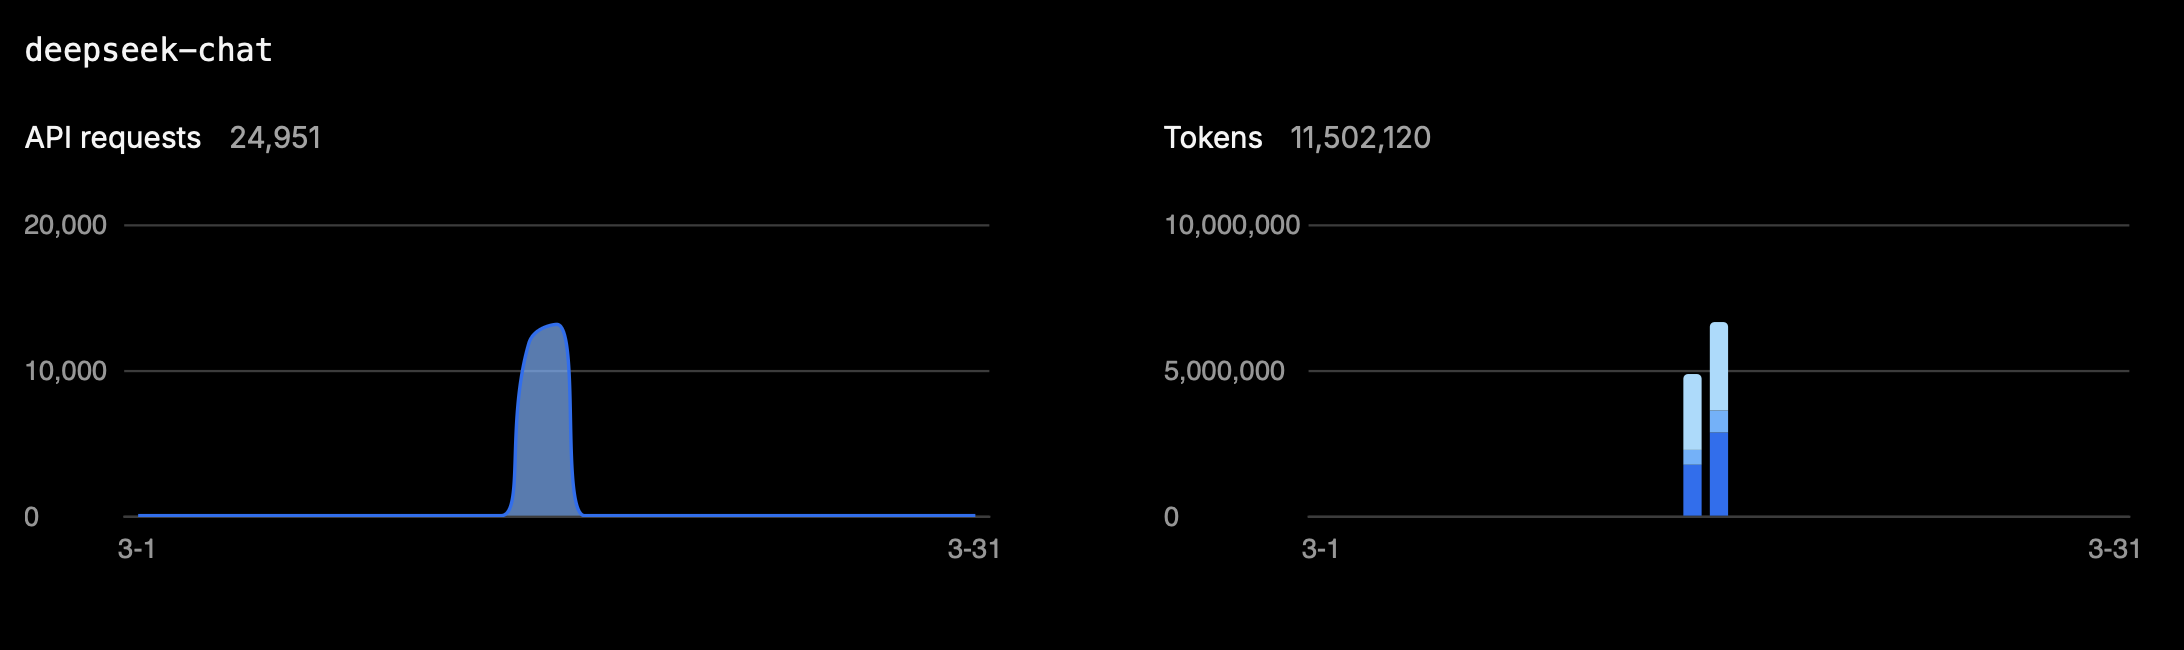

---

---

# TIỀN XỬ LÍ DỮ LIỆU

In [ ]:
import pandas as pd
import numpy as np
import torch

In [ ]:
#Đọc dữ liệu với dấu phân cách ";"
df = pd.read_csv("dataset.csv", encoding='utf-8-sig', sep=";")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#Đếm số lượng mẫu dữ liệu
total_samples = len(df)
print(f"Tổng số mẫu dữ liệu: {total_samples}")

Tổng số mẫu dữ liệu: 41818


In [ ]:
# xem info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41818 entries, 0 to 41817
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  41818 non-null  object
 1   Label    41818 non-null  object
dtypes: object(2)
memory usage: 653.5+ KB
None


In [ ]:
# xem 20 dòng dữ liệu đầu
print(df.head(20))

                                              Comment     Label
0   Buổi diễn này chẳng khác gì một trò đùa. Tôi c...  Negative
1   Một trận đấu ấn tượng, chúc mừng nhà vô địch mới.   Neutral
2   Cả hai đều có những tác phẩm đáng xem, tùy vào...   Neutral
3   Tôi đã từng ủng hộ nhưng giờ thì không nữa. Hợ...  Negative
4   Mình thấy VTuber này có nhiều tiềm năng. Hy vọ...  Positive
5   Cảm ơn những người đã dũng cảm lên tiếng. Sự k...  Positive
6   Bài viết thực sự mở mang đầu óc, tôi rất đồng ...  Positive
7   Cả hai bên đều có lý lẽ riêng, cần tìm điểm ch...   Neutral
8   Thật đáng mừng khi thấy OpenAI đã nhận ra sai ...  Positive
9   Việc phát ngôn gây tranh cãi là điều khó tránh...   Neutral
10  Thật thú vị khi thấy hai thiên tài công nghệ c...  Positive
11  Có vẻ như việc phụ thuộc vào patch đang trở th...   Neutral
12  Đây là vấn đề nhạy cảm. Cần sự minh bạch từ cả...   Neutral
13  Tôi thực sự thất vọng với sản phẩm này. Thiết ...  Negative
14  Không thể phủ nhận phim có sự đầu tư

In [ ]:
# Kiểm tra giá trị thiếu
print("\nSố giá trị thiếu:\n", df.isnull().sum())


Số giá trị thiếu:
 Comment    0
Label      0
dtype: int64


In [ ]:
# Kiểm tra số lượng mẫu theo từng nhãn
label_counts = df['Label'].value_counts()
print("\nSố lượng mẫu theo từng nhãn:\n", label_counts)


Số lượng mẫu theo từng nhãn:
 Label
Negative    14320
Positive    14112
Neutral     13386
Name: count, dtype: int64


Số lượng mẫu của 3 loại nhãn khá cân bằng

====> điều này giúp tránh bias khi huấn luyện mô hình

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize

<ipython-input-10-11e21d4b2864>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


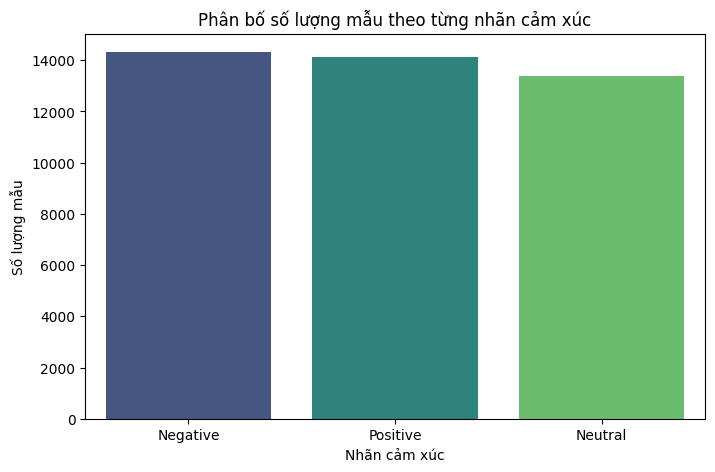

In [ ]:
# Biểu đồ cột: Phân bố số lượng mẫu theo nhãn cảm xúc**
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số lượng mẫu")
plt.title("Phân bố số lượng mẫu theo từng nhãn cảm xúc")
plt.show()

In [ ]:
print(df.columns)

Index(['Comment', 'Label'], dtype='object')


In [ ]:
# nltk.data.path.append('/usr/local/nltk_data')

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
text = "Xin chào! Đây là một câu thử nghiệm."
tokens = word_tokenize(text)
print(tokens)

['Xin', 'chào', '!', 'Đây', 'là', 'một', 'câu', 'thử', 'nghiệm', '.']


In [ ]:
#Đếm số từ trong mỗi văn bản**
# nltk.download('punkt')
df['word_count'] = df['Comment'].apply(lambda x: len(word_tokenize(str(x))))

<ipython-input-16-26adfd282540>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Label'], y=df['word_count'], palette="coolwarm")


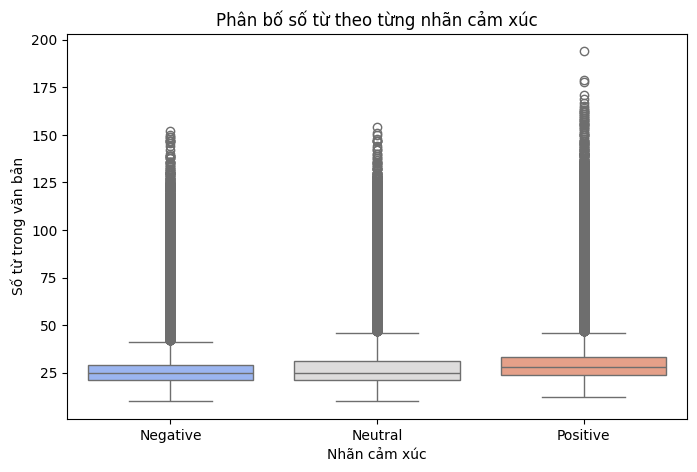

In [ ]:
# Boxplot: Độ dài câu theo từng nhãn cảm xúc**
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Label'], y=df['word_count'], palette="coolwarm")
plt.xlabel("Nhãn cảm xúc")
plt.ylabel("Số từ trong văn bản")
plt.title("Phân bố số từ theo từng nhãn cảm xúc")
plt.show()

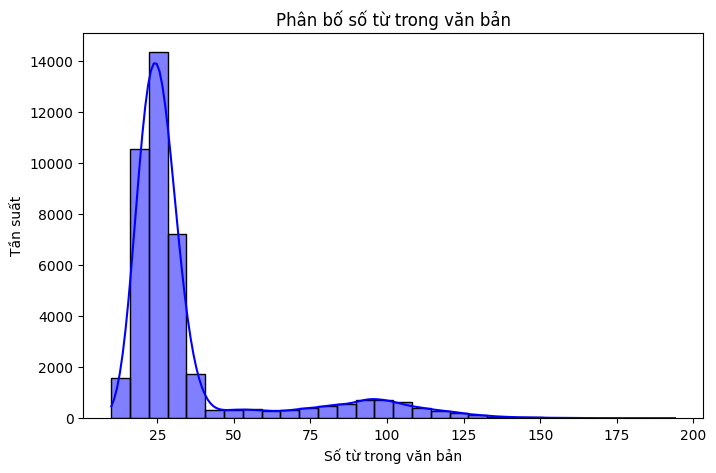

In [ ]:
# Histogram: Phân bố độ dài câu**
plt.figure(figsize=(8, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color="blue")
plt.xlabel("Số từ trong văn bản")
plt.ylabel("Tần suất")
plt.title("Phân bố số từ trong văn bản")
plt.show()

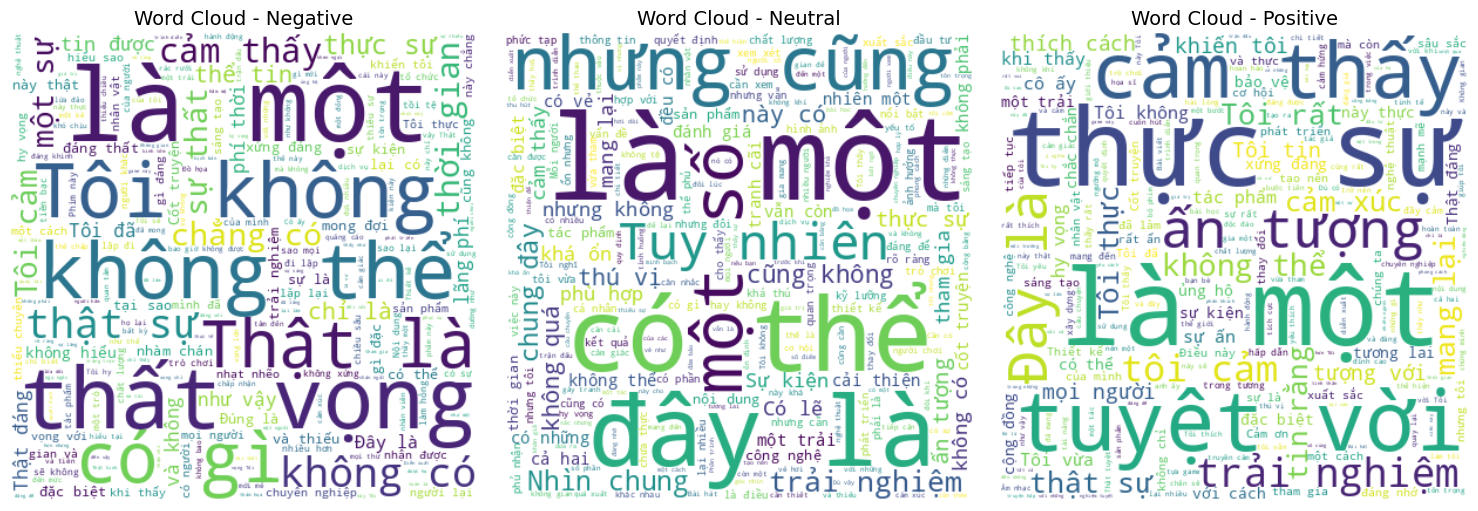

In [ ]:
# Word Cloud: Từ phổ biến nhất trong từng nhãn cảm xúc**
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels = df['Label'].unique()

for i, label in enumerate(labels):
    text = " ".join(df[df['Label'] == label]['Comment'])
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud - {label}", fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

Có nhiều chữ bình thường, xuất hiện cả ở 3 loại nhãn, đây là 1 vấn đề khá bình thường, nhưng cũng nên xư lí

Thường gặp ở các từ "trung tính"

 Nếu muốn Word Cloud rõ hơn, có 3 pp:

      1. Loại bỏ stopwords (từ không mang ý nghĩa).
      2. Chuyển văn bản về dạng chuẩn (bỏ dấu, ký tự đặc biệt).
      3. Dùng TF-IDF để đánh giá mức độ quan trọng của từ.

Chuẩn hóa văn bản (Loại bỏ ký tự thừa, viết tắt)

    1. Chuyển văn bản về chữ thường.
    2. Loại bỏ dấu câu, số, ký tự đặc biệt (. , ! ? @ ...).
    3. Chuẩn hóa các viết tắt, từ lóng (VD: "ko" → "không", "ok" → "đồng ý").

In [ ]:
import re

In [ ]:
# def clean_text(text):
#     # Chuyển về chữ thường
#     text = text.lower()
#     # Xóa số
#     text = re.sub(r'\d+', '', text)
#     # Xóa dấu câu, ký tự đặc biệt
#     text = re.sub(r'[^\w\s]', '', text)
#     # Xóa khoảng trắng thừa
#     text = text.strip()
#     return text

In [ ]:
def clean_text(text):
    # Chuyển về chữ thường
    text = text.lower()
    # Xóa số
    text = re.sub(r'\d+', '', text)
    # Giữ lại dấu tiếng Việt
    text = re.sub(r'[^\w\sàáạảãâầấậẩẫăằắặẳẵèéẹẻẽêềếệểễìíịỉĩòóọỏõôồốộổỗơờớợởỡùúụủũưừứựửữỳýỵỷỹđ]', '', text)
    # Xóa khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [ ]:
df.head(10)

,Comment,Label,word_count,cleaned_comment
0,Buổi diễn này chẳng khác gì một trò đùa. Tôi c...,Negative,24,buổi diễn này chẳng khác gì một trò đùa tôi cả...
1,"Một trận đấu ấn tượng, chúc mừng nhà vô địch mới.",Neutral,13,một trận đấu ấn tượng chúc mừng nhà vô địch mới
2,"Cả hai đều có những tác phẩm đáng xem, tùy vào...",Neutral,22,cả hai đều có những tác phẩm đáng xem tùy vào ...
3,Tôi đã từng ủng hộ nhưng giờ thì không nữa. Hợ...,Negative,26,tôi đã từng ủng hộ nhưng giờ thì không nữa hợp...
4,Mình thấy VTuber này có nhiều tiềm năng. Hy vọ...,Positive,29,mình thấy vtuber này có nhiều tiềm năng hy vọn...
5,Cảm ơn những người đã dũng cảm lên tiếng. Sự k...,Positive,28,cảm ơn những người đã dũng cảm lên tiếng sự ki...
6,"Bài viết thực sự mở mang đầu óc, tôi rất đồng ...",Positive,20,bài viết thực sự mở mang đầu óc tôi rất đồng t...
7,"Cả hai bên đều có lý lẽ riêng, cần tìm điểm ch...",Neutral,18,cả hai bên đều có lý lẽ riêng cần tìm điểm chu...
8,Thật đáng mừng khi thấy OpenAI đã nhận ra sai ...,Positive,36,thật đáng mừng khi thấy openai đã nhận ra sai ...
9,Việc phát ngôn gây tranh cãi là điều khó tránh...,Neutral,26,việc phát ngôn gây tranh cãi là điều khó tránh...


---

    Loại bỏ Stopwords tiếng Việt

- Stopwords là các từ không mang nhiều ý nghĩa trong phân loại cảm xúc như "là", "của", "và", "rất".

- Dùng danh sách stopwords tiếng Việt từ thư viện underthesea hoặc từ nguồn vietnamese-stopwords.



In [ ]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.0 MB/s eta 0:00:00


In [ ]:
import requests

In [ ]:
# Tải danh sách stopwords tiếng Việt
url = "https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt"

stopwords_vietnamese = set(requests.get(url).text.split("\n"))

In [ ]:
print("Số lượng stopwords tiếng Việt:", len(stopwords_vietnamese))

Số lượng stopwords tiếng Việt: 1942


In [ ]:
stopwords_vietnamese

{'úi chà',
 'tạo ý',
 'hay hay',
 'sa sả',
 'người nghe',
 'đã là',
 'bức',
 'phía dưới',
 'chăng nữa',
 'ấy',
 'ngày qua',
 'thêm',
 'chưa bao giờ',
 'ăn làm',
 'cuốn',
 'xem ra',
 'tháng tháng',
 'thì phải',
 'mở mang',
 'làm riêng',
 'ăn tay',
 'cái gì',
 'trước hết',
 'những lúc',
 'đúng tuổi',
 'thoạt',
 'thực ra',
 'ở lại',
 'đến khi',
 'mọi nơi',
 'như',
 'có đáng',
 'sì sì',
 'chị bộ',
 'anh ấy',
 'xuống',
 'gây',
 'ai ai',
 'tò te',
 'ừ ừ',
 'duy có',
 'lại còn',
 'cơ hồ',
 'thuộc cách',
 'bác',
 'riêng từng',
 'khó biết',
 'dù',
 'vâng ý',
 'đang thì',
 'ăn sáng',
 'cụ thể',
 'ào vào',
 'cả thảy',
 'khó mở',
 'quận',
 'quá tay',
 'vào đến',
 'vậy nên',
 'của tin',
 'ngày',
 'bà',
 'nước đến',
 'mỗi lúc',
 'như sau',
 'người nhận',
 'tìm việc',
 'nhỏ người',
 'đâu đó',
 'nhất loạt',
 'bỗng nhưng',
 'vì vậy',
 'việc',
 'có chuyện',
 'những',
 'sẽ hay',
 'bán thế',
 'chỉ',
 'rõ thật',
 'tăng chúng',
 'nặng căn',
 'đầy tuổi',
 'nước',
 'phải chăng',
 'nhất sinh',
 'nước bài',
 'n

    Tách từ tiếng Việt (Tokenization)

- Tiếng Việt là ngôn ngữ dính kết, tức là các từ có thể ghép thành một cụm từ có nghĩa ("học máy", "trí tuệ nhân tạo"). Nếu chỉ tách từng chữ đơn lẻ, mô hình sẽ mất ngữ nghĩa.

 - Dùng underthesea.word_tokenize() để tách từ chính xác hơn.



In [ ]:
from underthesea import word_tokenize

In [ ]:
# Tạo danh sách stopwords **không loại bỏ từ mang cảm xúc**
important_words = {"không", "rất", "quá", "tệ", "tốt", "thích", "buồn", "vui", "ghét"}
stopwords_vietnamese = stopwords_vietnamese - important_words

def remove_stopwords(text):
    #token
    words = word_tokenize(text, format="text")
    words = words.split()
    words = [word for word in words if word not in stopwords_vietnamese]
    return " ".join(words)

In [ ]:
df['cleaned_comment'] = df['cleaned_comment'].apply(remove_stopwords)

In [ ]:
df.head(10)

,Comment,Label,word_count,cleaned_comment
0,Buổi diễn này chẳng khác gì một trò đùa. Tôi c...,Negative,24,diễn chẳng khác_gì trò đùa cảm_thấy lãng_phí t...
1,"Một trận đấu ấn tượng, chúc mừng nhà vô địch mới.",Neutral,13,trận đấu ấn_tượng chúc_mừng vô_địch
2,"Cả hai đều có những tác phẩm đáng xem, tùy vào...",Neutral,22,hai tác_phẩm tùy sở_thích cá_nhân thích
3,Tôi đã từng ủng hộ nhưng giờ thì không nữa. Hợ...,Negative,26,ủng_hộ không hợp_đồng độc_quyền đi tự_do
4,Mình thấy VTuber này có nhiều tiềm năng. Hy vọ...,Positive,29,vtuber tiềm_năng hy_vọng khó_khăn tiếp_tục phá...
5,Cảm ơn những người đã dũng cảm lên tiếng. Sự k...,Positive,28,cảm_ơn dũng_cảm lên_tiếng sự_kiện thay_đổi chú...
6,"Bài viết thực sự mở mang đầu óc, tôi rất đồng ...",Positive,20,viết thực_sự mở_mang đầu_óc rất đồng_tình quan...
7,"Cả hai bên đều có lý lẽ riêng, cần tìm điểm ch...",Neutral,18,hai lý_lẽ phát_triển
8,Thật đáng mừng khi thấy OpenAI đã nhận ra sai ...,Positive,36,mừng openai sai_lầm sửa_chữa kịp_thời_sự sam a...
9,Việc phát ngôn gây tranh cãi là điều khó tránh...,Neutral,26,phát_ngôn tranh_cãi quan_trọng xử_lý hậu_quả r...


---

---

    Chuẩn hóa chính tả

- Người dùng có thể viết sai chính tả, ví dụ "ngon quá trời" → "ngon quá chời".
- Cần chuẩn hóa lại để tránh lỗi khi mô hình học.


- Thư viện xử dụng là pyvi

Khi nào cần xử dụng? (vì bài này chúng ta dùng LLMs sinh, nên chắc sẽ không gặp lỗi này, nhưng nên dùng cho an toàn)

- Nếu dữ liệu có nhiều lỗi chính tả.
- Nếu dữ liệu đến từ mạng xã hội, nơi có nhiều cách viết sai.

In [ ]:
!pip install pyvi

In [ ]:
# from pyvi import ViUtils

# # Loại bỏ dấu tiếng Việt
# df['cleaned_comment'] = df['cleaned_comment'].apply(lambda x: ViUtils.remove_accents(x))

 - Tiếng việt rất phụ thuộc vào dấu câu, nên việc loại bỏ dấu là không nên, dễ gây mất nghĩa, gây hiểu lầm, mất ngữ cảnh

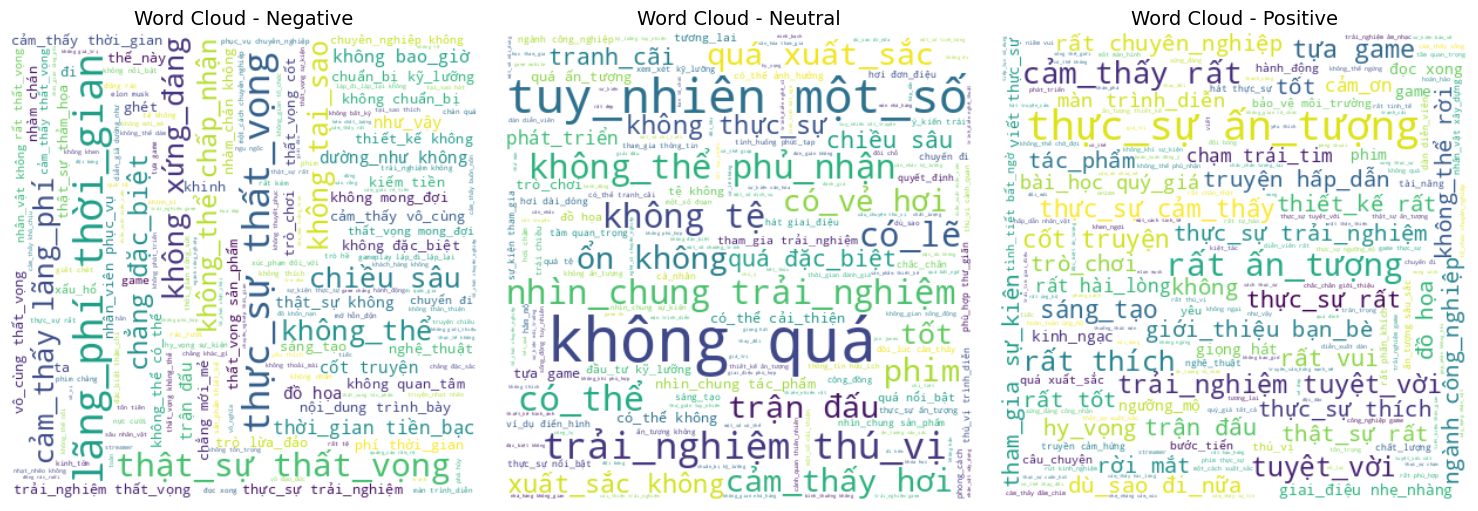

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
labels = df['Label'].unique()

for i, label in enumerate(labels):
    text = " ".join(df[df['Label'] == label]['cleaned_comment'])
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Word Cloud - {label}", fontsize=14)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# 2. Trình bày các phương pháp biểu diễn thông thường (Bag of Words) và áp dụng các phương pháp học máy truyền thống như Naive Bayesian classification, Logistic Regression, Decision Tree, …

# 2.1 BOW (Bag of words)

    Bag of Words là gì?

- Bag of Words (BoW) là phương pháp biểu diễn văn bản bằng cách đếm số lần xuất hiện của từ trong tài liệu.

     - Count Vectorizer (BoW cơ bản)

    - Binary BoW

    - TF Vectorizer

    - TF-IDF (biến thể của BOW)

    - N-grams (Bigram/Trigram)

- Các bước của Bow

    1. Biên dịch dữ liệu.

    2. Xử lý trước dữ liệu nếu cần.

    3. Lập danh sách tất cả các từ trong vốn từ vựng của mô hình.

    4. Đánh giá các từ trong mỗi tài liệu và tạo các vectơ tài liệu.

- Ưu điểm của BOW

    bag-of-words lý tưởng cho các tác vụ đơn giản như phân tích tình cảm, lọc thư rác và nhận dạng ngôn ngữ.

# Khởi tạo BoW

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Count Vectorizer (BoW cơ bản)

In [ ]:
# 1.Count Vectorizer (BoW cơ bản - Đếm số lần xuất hiện)
vectorizer_bow = CountVectorizer(max_features=5000)
X_bow = vectorizer_bow.fit_transform(df['cleaned_comment'])

# Binary BoW

In [ ]:
# 2.Binary BoW (Chỉ quan tâm từ có xuất hiện hay không)
vectorizer_binary = CountVectorizer(max_features=5000, binary=True)
X_binary_bow = vectorizer_binary.fit_transform(df['cleaned_comment'])

# TF Vectorizer

In [ ]:
# 3.Term Frequency (TF - Normalized BoW)
vectorizer_tf = CountVectorizer(max_features=5000)
X_tf = vectorizer_tf.fit_transform(df['cleaned_comment']).astype(float)
# Chuẩn hóa theo hàng để có TF
X_tf = X_tf / X_tf.sum(axis=1)

# TF-IDF (biến thể của BOW)

- TF-IDF (Term Frequency - Inverse Document Frequency) giúp đánh giá mức độ quan trọng của từ trong văn bản so với toàn bộ tập dữ liệu.

In [ ]:
# 4.TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer_tfidf.fit_transform(df['cleaned_comment'])

# N-grams (Bigram - Xét cặp từ liên tiếp)

In [ ]:
# 5.N-grams (Bigram - Xét cặp từ liên tiếp)
vectorizer_bigram = CountVectorizer(max_features=5000, ngram_range=(2, 2))
X_bigram = vectorizer_bigram.fit_transform(df['cleaned_comment'])

# N-grams (Trigram - xét bộ ba từ liên tiếp)

In [ ]:
# 6.N-grams (Trigram - Xét bộ ba từ liên tiếp)
vectorizer_trigram = CountVectorizer(max_features=5000, ngram_range=(3, 3))
X_trigram = vectorizer_trigram.fit_transform(df['cleaned_comment'])

# Chuyển đổi nhãn (Label Encoding)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
# Chuyển đổi thành số (0: Negative, 1: Neutral, 2: Positive)
y = label_encoder.fit_transform(df['Label'])

# Chạy các mô hình truyền thống trên BoW, TF-IDF....

## Chia dữ liệu thành tập train/test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Chia dữ liệu thành train và test (80% train, 20% test)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)
X_train_binary, X_test_binary, _, _ = train_test_split(X_binary_bow, y, test_size=0.2, random_state=42)
X_train_tf, X_test_tf, _, _ = train_test_split(X_tf, y, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf, _, _ = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
X_train_bigram, X_test_bigram, _, _ = train_test_split(X_bigram, y, test_size=0.2, random_state=42)
X_train_trigram, X_test_trigram, _, _ = train_test_split(X_trigram, y, test_size=0.2, random_state=42)

In [ ]:
nb_train_data = [X_train_bow, X_train_binary, X_train_tf, X_train_tfidf, X_train_bigram, X_train_trigram]
nb_test_data = [X_test_bow, X_test_binary, X_test_tf, X_test_tfidf, X_test_bigram, X_test_trigram]

    2.1 Naive Bayes (Phù hợp với dữ liệu văn bản vì giả định độc lập có điều kiện giữa các từ)


    2.2 Logistic Regression (Hiệu quả với phân loại văn bản, dễ huấn luyện)


    2.3 Decision Tree (Giải thích dễ nhưng có thể overfitting)

# 2.1 Naive Bayesian classification

In [ ]:
# !pip uninstall numpy -y

In [ ]:
# !pip install numpy

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
nb_models = {
    "Naive Bayes (BoW)": MultinomialNB(),
    "Naive Bayes (Binary)": MultinomialNB(),
    "Naive Bayes (TF)": MultinomialNB(),
    "Naive Bayes (TF-IDF)": MultinomialNB(),
    "Naive Bayes (Bigram)": MultinomialNB(),
    "Naive Bayes (Trigram)": MultinomialNB()
}

for (name, model), X_train, X_test in zip(nb_models.items(), nb_train_data, nb_test_data):
    if isinstance(X_train, np.matrix):
        X_train = np.asarray(X_train)
    if isinstance(X_test, np.matrix):
        X_test = np.asarray(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("------------------------------------------------------")


Naive Bayes (BoW):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      2909
           1       0.91      0.90      0.90      2633
           2       0.91      0.91      0.91      2822

    accuracy                           0.93      8364
   macro avg       0.93      0.93      0.93      8364
weighted avg       0.93      0.93      0.93      8364

Accuracy: 0.9275
------------------------------------------------------

Naive Bayes (Binary):
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2909
           1       0.91      0.89      0.90      2633
           2       0.91      0.91      0.91      2822

    accuracy                           0.93      8364
   macro avg       0.93      0.93      0.93      8364
weighted avg       0.93      0.93      0.93      8364

Accuracy: 0.9284
------------------------------------------------------

Naive Bayes (TF):
              precision    recal

# 2.2 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr_models = {
    "Logistic Regression (BoW)": LogisticRegression(max_iter=1000),
    "Logistic Regression (Binary)": LogisticRegression(max_iter=1000),
    "Logistic Regression (TF)": LogisticRegression(max_iter=1000),
    "Logistic Regression (TF-IDF)": LogisticRegression(max_iter=1000),
    "Logistic Regression (Bigram)": LogisticRegression(max_iter=1000),
    "Logistic Regression (Trigram)": LogisticRegression(max_iter=1000)
}

for (name, model), X_train, X_test in zip(lr_models.items(), nb_train_data, nb_test_data):
    if isinstance(X_train, np.matrix):
        X_train = np.asarray(X_train)
    if isinstance(X_test, np.matrix):
        X_test = np.asarray(X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("------------------------------------------------------")


Logistic Regression (BoW):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2909
           1       0.93      0.94      0.94      2633
           2       0.94      0.94      0.94      2822

    accuracy                           0.95      8364
   macro avg       0.95      0.95      0.95      8364
weighted avg       0.95      0.95      0.95      8364

Accuracy: 0.9521
------------------------------------------------------

Logistic Regression (Binary):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2909
           1       0.93      0.94      0.94      2633
           2       0.94      0.95      0.94      2822

    accuracy                           0.95      8364
   macro avg       0.95      0.95      0.95      8364
weighted avg       0.95      0.95      0.95      8364

Accuracy: 0.9527
------------------------------------------------------

Logistic Regression (TF):
        

# 2.3 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
dt_models = {
    "Decision Tree (BoW)": DecisionTreeClassifier(max_depth=40, random_state=42),
    "Decision Tree (Binary)": DecisionTreeClassifier(max_depth=40, random_state=42),
    "Decision Tree (TF)": DecisionTreeClassifier(max_depth=40, random_state=42),
    "Decision Tree (TF-IDF)": DecisionTreeClassifier(max_depth=40, random_state=42),
    "Decision Tree (Bigram)": DecisionTreeClassifier(max_depth=40, random_state=42),
    "Decision Tree (Trigram)": DecisionTreeClassifier(max_depth=40, random_state=42)
}
# thử nghiệm lần 1, max_depth =10 -> acc chỉ đạt ~30% -> kq quá xấu
# lần 2, khi tăng lên 20 -> kq lên được 4x% -> cho thấy kq đã được cải thiện
# lần 3, lên 40 thì kq đã khá hơn rất nhiều, tuy nhiên vẫn rất xấu ở N-grams

for (name, model), X_train, X_test in zip(dt_models.items(), nb_train_data, nb_test_data):

    X_train = X_train.toarray()
    X_test = X_test.toarray()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("------------------------------------------------------")


Decision Tree (BoW):
              precision    recall  f1-score   support

           0       0.95      0.78      0.86      2909
           1       0.69      0.92      0.79      2633
           2       0.90      0.79      0.84      2822

    accuracy                           0.83      8364
   macro avg       0.85      0.83      0.83      8364
weighted avg       0.85      0.83      0.83      8364

Accuracy: 0.8275
------------------------------------------------------

Decision Tree (Binary):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      2909
           1       0.70      0.92      0.79      2633
           2       0.90      0.78      0.84      2822

    accuracy                           0.83      8364
   macro avg       0.85      0.83      0.83      8364
weighted avg       0.85      0.83      0.83      8364

Accuracy: 0.8270
------------------------------------------------------

Decision Tree (TF):
              precision   

# 2.4 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_models = {
    "Random Forest (BoW)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Random Forest (Binary)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Random Forest (TF)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Random Forest (TF-IDF)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Random Forest (Bigram)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42),
    "Random Forest (Trigram)": RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
}

#---
# Thử nghiệm lần 1 với n_estimators = 100 và max_depth = 10 -> cho thấy kq không ổn, khá xấu, đặc biệt nhấtlà trigram chỉ 44% acc
#---
# Thử nghiệm lần , tăng  n_extimators lên 300 và max_depth lên 20 thì kq đã được cải thiện
#---

for (name, model), X_train, X_test in zip(rf_models.items(), nb_train_data, nb_test_data):
    if isinstance(X_train, np.matrix):
        X_train = np.asarray(X_train)
    if isinstance(X_test, np.matrix):
        X_test = np.asarray(X_test)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("------------------------------------------------------")


Random Forest (BoW):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2909
           1       0.89      0.84      0.86      2633
           2       0.85      0.90      0.88      2822

    accuracy                           0.89      8364
   macro avg       0.89      0.89      0.89      8364
weighted avg       0.89      0.89      0.89      8364

Accuracy: 0.8895
------------------------------------------------------

Random Forest (Binary):
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2909
           1       0.88      0.84      0.86      2633
           2       0.85      0.90      0.87      2822

    accuracy                           0.89      8364
   macro avg       0.89      0.88      0.89      8364
weighted avg       0.89      0.89      0.89      8364

Accuracy: 0.8861
------------------------------------------------------

Random Forest (TF):
              precision   

# 2.4  So sánh các mô hình

In [ ]:
#!pip install ace-tools

In [ ]:
# Tạo DataFrame chứa kết quả so sánh
df_comparison = pd.DataFrame({
    "Phương pháp": [
        "Naive Bayes (BoW)", "Naive Bayes (TF-IDF)", "Naive Bayes (Binary)", "Naive Bayes (TF)", "Naive Bayes (Bigram)", "Naive Bayes (Trigram)",
        "Logistic Regression (BoW)", "Logistic Regression (TF-IDF)", "Logistic Regression (Binary)", "Logistic Regression (TF)", "Logistic Regression (Bigram)", "Logistic Regression (Trigram)",
        "Decision Tree (BoW)", "Decision Tree (TF-IDF)", "Decision Tree (Binary)", "Decision Tree (TF)", "Decision Tree (Bigram)", "Decision Tree (Trigram)",
        "Random Forest (BoW)", "Random Forest (TF-IDF)", "Random Forest (Binary)", "Random Forest (TF)", "Random Forest (Bigram)", "Random Forest (Trigram)"
    ],
    "Accuracy (%)": [
        accuracy_score(y_test, nb_models["Naive Bayes (BoW)"].predict(X_test_bow)) * 100,
        accuracy_score(y_test, nb_models["Naive Bayes (TF-IDF)"].predict(X_test_tfidf)) * 100,
        accuracy_score(y_test, nb_models["Naive Bayes (Binary)"].predict(X_test_binary)) * 100,
        accuracy_score(y_test, nb_models["Naive Bayes (TF)"].predict(X_test_tf)) * 100,
        accuracy_score(y_test, nb_models["Naive Bayes (Bigram)"].predict(X_test_bigram)) * 100,
        accuracy_score(y_test, nb_models["Naive Bayes (Trigram)"].predict(X_test_trigram)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (BoW)"].predict(X_test_bow)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (TF-IDF)"].predict(X_test_tfidf)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (Binary)"].predict(X_test_binary)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (TF)"].predict(X_test_tf)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (Bigram)"].predict(X_test_bigram)) * 100,
        accuracy_score(y_test, lr_models["Logistic Regression (Trigram)"].predict(X_test_trigram)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (BoW)"].predict(X_test_bow)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (TF-IDF)"].predict(X_test_tfidf)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (Binary)"].predict(X_test_binary)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (TF)"].predict(X_test_tf)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (Bigram)"].predict(X_test_bigram)) * 100,
        accuracy_score(y_test, dt_models["Decision Tree (Trigram)"].predict(X_test_trigram)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (BoW)"].predict(X_test_bow)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (TF-IDF)"].predict(X_test_tfidf)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (Binary)"].predict(X_test_binary)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (TF)"].predict(X_test_tf)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (Bigram)"].predict(X_test_bigram)) * 100,
        accuracy_score(y_test, rf_models["Random Forest (Trigram)"].predict(X_test_trigram)) * 100,
    ]
})

In [ ]:
from tabulate import tabulate

In [ ]:
print(tabulate(df_comparison, headers="keys", tablefmt="pretty"))

+----+-------------------------------+--------------------+
|    |          Phương pháp          |    Accuracy (%)    |
+----+-------------------------------+--------------------+
| 0  |       Naive Bayes (BoW)       | 92.75466284074605  |
| 1  |     Naive Bayes (TF-IDF)      | 92.67097082735533  |
| 2  |     Naive Bayes (Binary)      | 92.83835485413677  |
| 3  |       Naive Bayes (TF)        |  92.0492587278814  |
| 4  |     Naive Bayes (Bigram)      | 86.52558584409374  |
| 5  |     Naive Bayes (Trigram)     | 63.84505021520803  |
| 6  |   Logistic Regression (BoW)   | 95.20564323290291  |
| 7  | Logistic Regression (TF-IDF)  |  94.8469631755141  |
| 8  | Logistic Regression (Binary)  | 95.26542324246772  |
| 9  |   Logistic Regression (TF)    | 92.07317073170732  |
| 10 | Logistic Regression (Bigram)  | 88.09182209469154  |
| 11 | Logistic Regression (Trigram) | 64.56241032998565  |
| 12 |      Decision Tree (BoW)      | 82.74748923959828  |
| 13 |    Decision Tree (TF-IDF)     | 8

# 3. Sử dụng cách biểu diễn Doc2vec sử dụng Deep Learning (Có/Không sử dụng)


    Doc2vec là gì?

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
!pip install numpy==1.24.3
!pip install --force-reinstall gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which i

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/

ModuleNotFoundError: No module named 'numpy.char'

In [ ]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [ ]:
import gensim
print("Gensim version:", gensim.__version__)

Gensim version: 4.3.3


In [ ]:
import torch
#pytorch tự động GOU rồi, nhưng gán cho chắc chắc nó sử dụng
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Sử dụng thiết bị:", device)

Sử dụng thiết bị: cuda


- Doc2Vec	Chuyển văn bản thành vector 300 chiều, giúp giữ ngữ cảnh.

- FastText	Giống Word2Vec nhưng tốt hơn với từ chưa có trong từ điển.

- PhoBERT	Mô hình Transformer pretrain, mạnh nhất trong NLP.

# 3.1 Không sử dụng pretrain models

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
#Chuẩn bị dữ liệu cho Doc2Vec
documents = [TaggedDocument(words=text.split(), tags=[i]) for i, text in enumerate(df['cleaned_comment'])]
y = df['Label'].values

In [ ]:
y

array(['Negative', 'Neutral', 'Neutral', ..., 'Negative', 'Negative',
       'Positive'], dtype=object)

In [ ]:
# Khởi tạo Doc2Vec (DM & DBOW)
model_dm = Doc2Vec(vector_size=100, window=5, min_count=2, workers=8, epochs=50, dm=1)
model_dbow = Doc2Vec(vector_size=100, window=5, min_count=2, workers=8, epochs=50, dm=0)

In [ ]:
# Xây dựng từ vựng
model_dm.build_vocab(documents)
model_dbow.build_vocab(documents)

In [ ]:
# Train
print("Training Doc2Vec (PV-DM)")
model_dm.train(documents, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)

print("Training Doc2Vec (PV-DBOW)")
model_dbow.train(documents, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

Training Doc2Vec (PV-DM)
Training Doc2Vec (PV-DBOW)


In [ ]:
# Lưu lại mô hình
model_dm.save("doc2vec_dm.model")
model_dbow.save("doc2vec_dbow.model")

In [ ]:
# Chuyển thành vector
X_dm = np.array([model_dm.dv[i] for i in range(len(documents))])
X_dbow = np.array([model_dbow.dv[i] for i in range(len(documents))])

In [ ]:
# Chia tập train/test
X_train_dm, X_test_dm, y_train, y_test = train_test_split(X_dm, y, test_size=0.2, random_state=42)
X_train_dbow, X_test_dbow, _, _ = train_test_split(X_dbow, y, test_size=0.2, random_state=42)

In [ ]:
print("Đã train xong Doc2Vec từ đầu và chuẩn bị dữ liệu!")

Đã train xong Doc2Vec từ đầu và chuẩn bị dữ liệu!


# PRETRAINED Doc2Vec

In [ ]:
import numpy as np

In [ ]:
print("Đang load lại Word2Vec được train sẵn...")
pretrained_w2v = gensim.models.KeyedVectors.load_word2vec_format("wiki.vi.model.bin", binary=True)
# Tự động lấy kích thước vector
vector_size = pretrained_w2v.vector_size

Đang load lại Word2Vec được train sẵn...


In [ ]:
# Chuyển câu thành vector trung bình từ Word2Vec
def get_sentence_vector(sentence, model, vector_size=vector_size):
    words = sentence.split()
    vectors = [model[word] for word in words if word in model]

    if vectors:
        # Tính trung bình vector các từ
        return np.mean(vectors, axis=0)
    else:
        # Trả về vector 0 nếu không có từ nào
        return np.zeros(vector_size)

In [ ]:
# Chuyển dataset thành vector
X_pretrain = np.array([get_sentence_vector(text, pretrained_w2v, vector_size) for text in df['cleaned_comment']])

In [ ]:
# Chia tập train/test
X_train_pretrain, X_test_pretrain, _, _ = train_test_split(X_pretrain, y, test_size=0.2, random_state=42)

print(f"Đã tạo xong Doc2Vec từ Pretrained Word2Vec! Vector size: {vector_size}")

In [ ]:
# Kiểm tra kích thước của X_pretrain
print(f"Kích thước X_pretrain: {X_pretrain.shape}")

Kích thước X_pretrain: (41818, 400)


In [ ]:
# Kiểm tra xem có NaN hoặc Inf không
print(f"Có NaN trong dữ liệu? {np.isnan(X_pretrain).any()}")
print(f"Có Inf trong dữ liệu? {np.isinf(X_pretrain).any()}")

Có NaN trong dữ liệu? False
Có Inf trong dữ liệu? False


In [ ]:
# Kiểm tra 5 vector đầu tiên
print("5 vector đầu tiên của X_pretrain:")
print(X_pretrain[:5])

5 vector đầu tiên của X_pretrain:
[[-0.47301847  0.93811572 -0.64096195 ... -0.24814183  0.98720092
   0.26795527]
 [ 1.46570516  0.95536506 -1.66047025 ... -1.55483317  0.68741524
  -0.32620174]
 [-0.18620892  0.65530819 -0.0126311  ... -1.03986442 -0.13878255
   0.07623577]
 [-1.48734391  1.13334358 -2.5054152  ... -0.16320565  0.54423082
   2.06366754]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


# THỬ NGHIỆM VỚI CÁC PP MACHINE LEARNING TRUYỀN THỐNG

In [ ]:
import numpy as np
import pandas as pd
import gensim
from sklearn.base import clone
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
ml_models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=500, solver="lbfgs"),
    "Decision Tree": DecisionTreeClassifier(max_depth=40, random_state=42)
}

In [ ]:
results = []
ml_models_dict = {}

# Chạy các mô hình trên cả 3 phương pháp
for method, (X_train, X_test) in [
    ("Doc2Vec-DM", (X_train_dm, X_test_dm)),
    ("Doc2Vec-DBOW", (X_train_dbow, X_test_dbow)),
    ("Pretrained Word2Vec", (X_train_pretrain, X_test_pretrain))
]:
    print(f"\n Đang huấn luyện các mô hình ML với phương pháp {method}...\n")

    # Lưu các mô hình đã huấn luyện riêng cho phương pháp này
    trained_models = {}

    for model_name, base_model in ml_models.items():
        # Tạo bản sao sạch để tránh ghi đè
        model = clone(base_model)
        print(f"Training {model_name} on {method}")

        # Huấn luyện
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Đánh giá mô hình
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)

        # Lưu kết quả
        results.append({
            "Method": method,
            "Model": model_name,
            "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
            "Test Accuracy": accuracy,
            "Precision": report["weighted avg"]["precision"],
            "Recall": report["weighted avg"]["recall"],
            "F1-score": report["weighted avg"]["f1-score"]
        })

        # Lưu model lại
        trained_models[model_name] = model

        print(f"{model_name} on {method} - Test Acc: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        print("-" * 60)

    # Gán vào dict toàn cục
    ml_models_dict[method] = trained_models

# Hiển thị bảng kết quả
df_results = pd.DataFrame(results)


 Đang huấn luyện các mô hình ML với phương pháp Doc2Vec-DM...

Training Naive Bayes on Doc2Vec-DM
Naive Bayes on Doc2Vec-DM - Test Acc: 0.5612
              precision    recall  f1-score   support

           0       0.51      0.74      0.60      2909
           1       0.72      0.40      0.52      2633
           2       0.56      0.52      0.54      2822

    accuracy                           0.56      8364
   macro avg       0.60      0.56      0.55      8364
weighted avg       0.59      0.56      0.55      8364

------------------------------------------------------------
Training Logistic Regression on Doc2Vec-DM
Logistic Regression on Doc2Vec-DM - Test Acc: 0.7378
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2909
           1       0.70      0.70      0.70      2633
           2       0.74      0.74      0.74      2822

    accuracy                           0.74      8364
   macro avg       0.74      0.74      0.74   

In [ ]:
import seaborn as sns

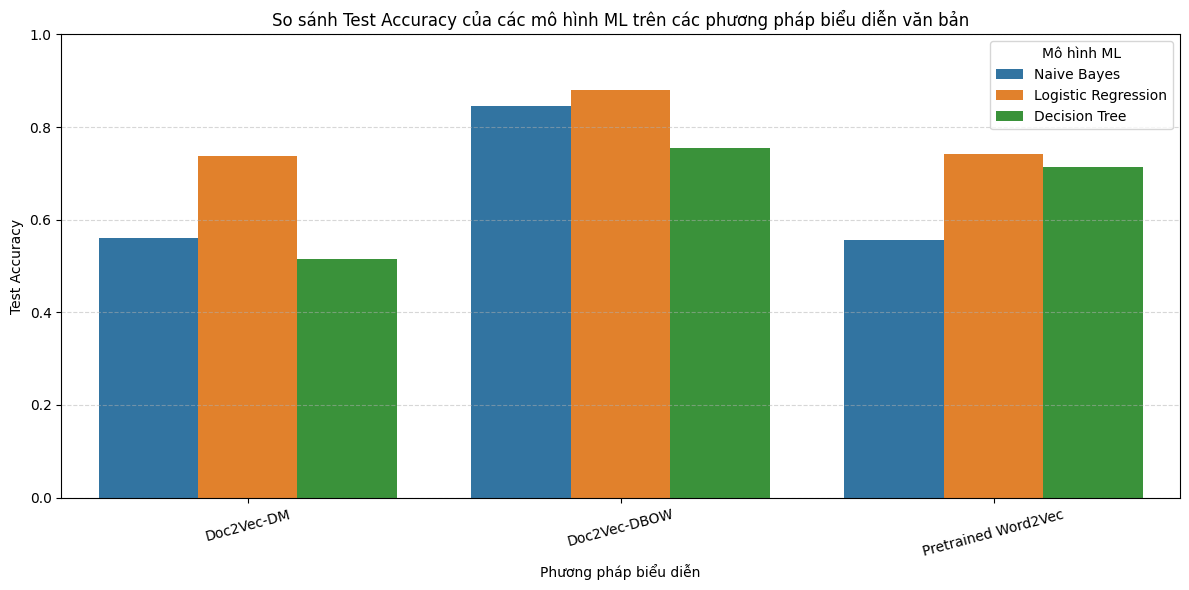

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Method", y="Test Accuracy", hue="Model")
plt.title("So sánh Test Accuracy của các mô hình ML trên các phương pháp biểu diễn văn bản")
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.xlabel("Phương pháp biểu diễn")
plt.legend(title="Mô hình ML")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

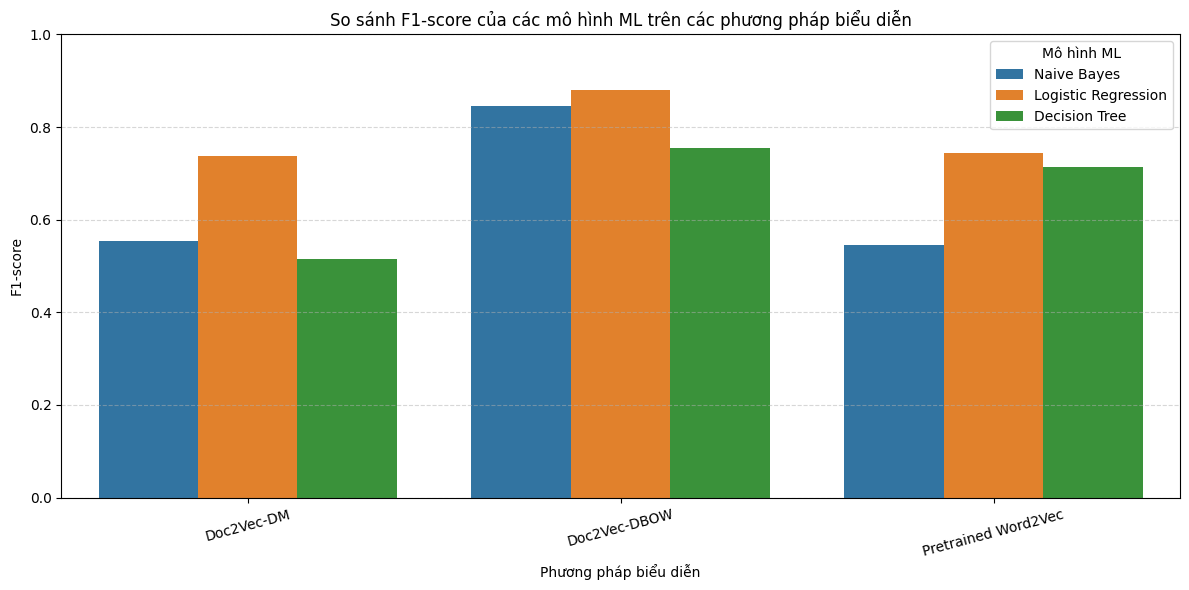

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Method", y="F1-score", hue="Model")
plt.title("So sánh F1-score của các mô hình ML trên các phương pháp biểu diễn")
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.xlabel("Phương pháp biểu diễn")
plt.legend(title="Mô hình ML")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# THỬ NGHIỆM VỚI CÁC PP DEEP LEARNING KHÁC

# 3.2 Các mô hình DL

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        # Chỉ lấy hidden state cuối cùng
        out = self.fc(hn[-1])
        return out

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_classes=3):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        # Bidirectional nên *2
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Nếu input có dạng (batch_size, input_dim)
        if x.dim() == 2:
            # Chuyển thành (batch_size, seq_len=1, input_dim)
            x = x.unsqueeze(1)

        # hn.shape = (2, batch_size, hidden_dim)
        lstm_out, (hn, _) = self.lstm(x)

        # Giải quyết lỗi Dimension out of range
        # Kiểm tra có đủ chiều bidirectional không
        if hn.shape[0] == 2:
            out = self.fc(torch.cat((hn[-2], hn[-1]), dim=1))
        # Nếu chỉ có 1 chiều, không phải BiLSTM
        else:
            out = self.fc(hn[-1])

        return out

# TRAIN DL

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import time

In [ ]:
def train_dl_model(model, model_name, method, X_train, y_train, X_test, y_test, epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Chuyển dữ liệu sang tensor (Ép kiểu đảm bảo không còn lỗi object)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.astype(int), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.astype(int), dtype=torch.long).to(device)

    # Reshape nếu là LSTM/BiLSTM
    if isinstance(model, (LSTMModel, BiLSTMModel)):
        if X_train_tensor.dim() == 2:
            X_train_tensor = X_train_tensor.unsqueeze(1)
            X_test_tensor = X_test_tensor.unsqueeze(1)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print(f"Training {model_name} on {method}...")
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            preds = model(X_test_tensor)
            test_preds = torch.argmax(preds, dim=1)
            acc = accuracy_score(y_test_tensor.cpu(), test_preds.cpu())

        print(f"Epoch {epoch+1}/{epochs} - Test Acc: {acc:.4f} - Loss: {loss.item():.4f}")

    # Đánh giá cuối
    model.eval()
    with torch.no_grad():
        train_preds = torch.argmax(model(X_train_tensor), dim=1)
        test_preds = torch.argmax(model(X_test_tensor), dim=1)

        train_acc = accuracy_score(y_train_tensor.cpu(), train_preds.cpu())
        test_acc = accuracy_score(y_test_tensor.cpu(), test_preds.cpu())
        precision = precision_score(y_test_tensor.cpu(), test_preds.cpu(), average="weighted", zero_division=1)
        recall = recall_score(y_test_tensor.cpu(), test_preds.cpu(), average="weighted")
        f1 = f1_score(y_test_tensor.cpu(), test_preds.cpu(), average="weighted")

    end_time = time.time()
    print(f"{model_name} on {method} - Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}, F1: {f1:.4f}, Time: {end_time - start_time:.2f}s")

    return {
        "Method": method,
        "Model": model_name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
 # y sẽ là mảng số nguyên (0, 1, 2)
y = label_encoder.fit_transform(df['Label'])

# Sau đó chia lại:
from sklearn.model_selection import train_test_split
X_train_dm, X_test_dm, y_train, y_test = train_test_split(X_dm, y, test_size=0.2, random_state=42)

In [ ]:
results_dl = []

for method, (X_train, X_test) in [
    ("Doc2Vec-DM", (X_train_dm, X_test_dm)),
    ("Doc2Vec-DBOW", (X_train_dbow, X_test_dbow)),
    ("Pretrained Word2Vec", (X_train_pretrain, X_test_pretrain))
]:
    print(f"\n Huấn luyện các mô hình DL với phương pháp {method}...")

    input_dim = X_train.shape[1]
    models = {
        "MLP": MLP(input_dim=input_dim, num_classes=3),
        "LSTM": LSTMModel(input_dim=input_dim, hidden_dim=128, num_classes=3),
        "BiLSTM": BiLSTMModel(input_dim=input_dim, hidden_dim=128, num_classes=3)
    }

    for model_name, model in models.items():
        res = train_dl_model(model, model_name, method, X_train, y_train, X_test, y_test)
        results_dl.append(res)


 Huấn luyện các mô hình DL với phương pháp Doc2Vec-DM...
Training MLP on Doc2Vec-DM...
Epoch 1/20 - Test Acc: 0.3551 - Loss: 1.0972
Epoch 2/20 - Test Acc: 0.3966 - Loss: 1.0930
Epoch 3/20 - Test Acc: 0.4536 - Loss: 1.0889
Epoch 4/20 - Test Acc: 0.4986 - Loss: 1.0848
Epoch 5/20 - Test Acc: 0.5328 - Loss: 1.0806
Epoch 6/20 - Test Acc: 0.5533 - Loss: 1.0765
Epoch 7/20 - Test Acc: 0.5734 - Loss: 1.0722
Epoch 8/20 - Test Acc: 0.5855 - Loss: 1.0679
Epoch 9/20 - Test Acc: 0.5928 - Loss: 1.0634
Epoch 10/20 - Test Acc: 0.5978 - Loss: 1.0588
Epoch 11/20 - Test Acc: 0.6032 - Loss: 1.0541
Epoch 12/20 - Test Acc: 0.6107 - Loss: 1.0491
Epoch 13/20 - Test Acc: 0.6157 - Loss: 1.0439
Epoch 14/20 - Test Acc: 0.6221 - Loss: 1.0385
Epoch 15/20 - Test Acc: 0.6302 - Loss: 1.0329
Epoch 16/20 - Test Acc: 0.6352 - Loss: 1.0270
Epoch 17/20 - Test Acc: 0.6440 - Loss: 1.0209
Epoch 18/20 - Test Acc: 0.6505 - Loss: 1.0145
Epoch 19/20 - Test Acc: 0.6573 - Loss: 1.0079
Epoch 20/20 - Test Acc: 0.6625 - Loss: 1.0011
M

In [ ]:
df_dl_results = pd.DataFrame(results_dl)

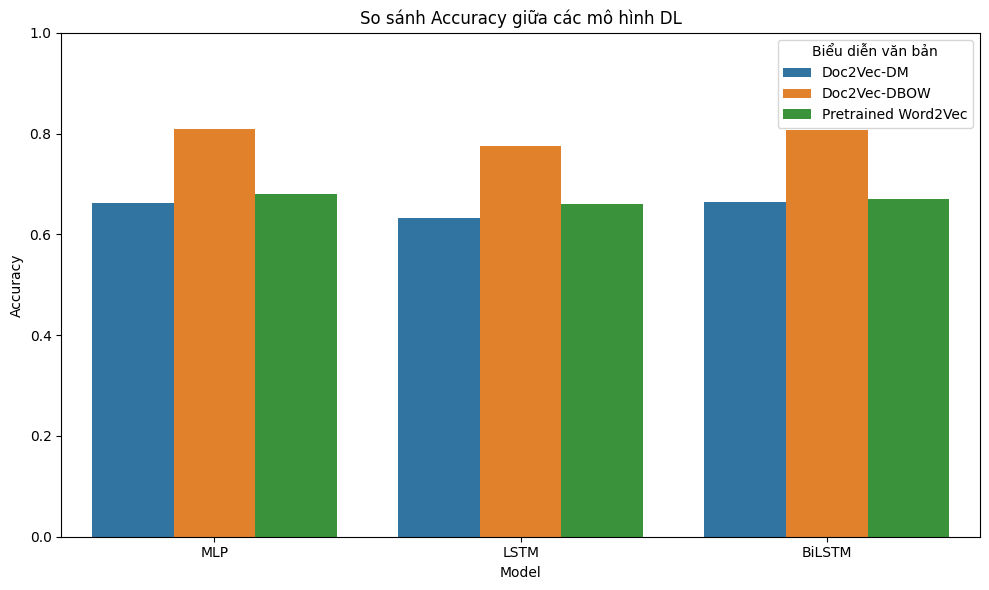

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dl_results, x="Model", y="Test Accuracy", hue="Method")
plt.title("So sánh Accuracy giữa các mô hình DL")
plt.ylim(0, 1)
plt.ylabel("Accuracy")
plt.legend(title="Biểu diễn văn bản")
plt.tight_layout()
plt.show()

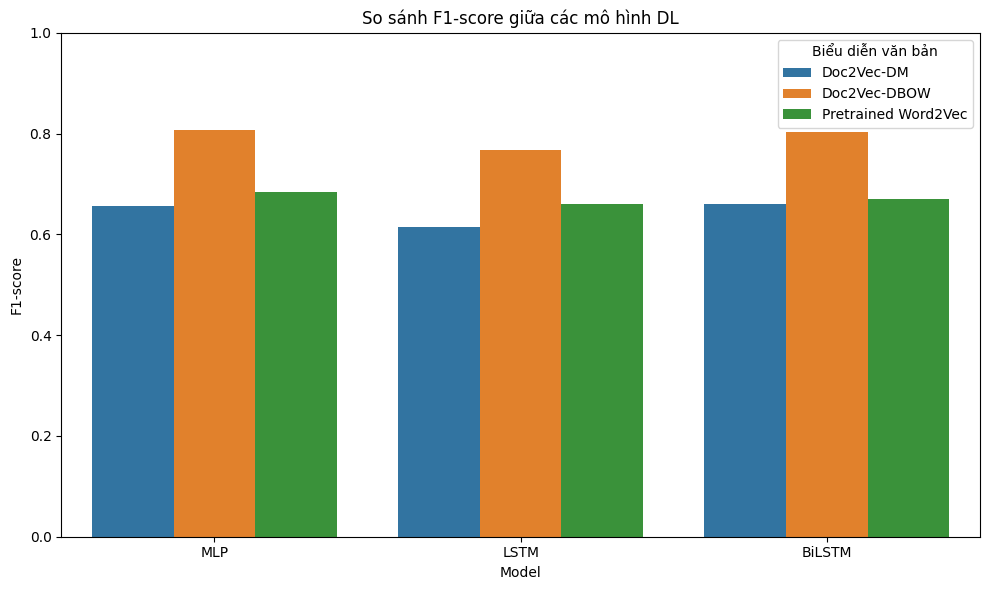

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dl_results, x="Model", y="F1-score", hue="Method")
plt.title("So sánh F1-score giữa các mô hình DL")
plt.ylim(0, 1)
plt.ylabel("F1-score")
plt.legend(title="Biểu diễn văn bản")
plt.tight_layout()
plt.show()

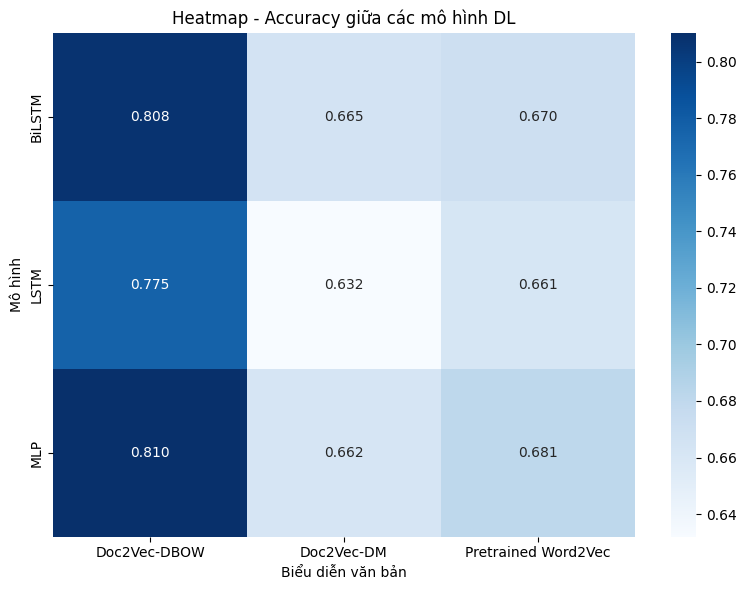

In [ ]:
pivot_acc = df_dl_results.pivot(index="Model", columns="Method", values="Test Accuracy")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_acc, annot=True, fmt=".3f", cmap="Blues")
plt.title("Heatmap - Accuracy giữa các mô hình DL")
plt.ylabel("Mô hình")
plt.xlabel("Biểu diễn văn bản")
plt.tight_layout()
plt.show()

# So sánh cả ML,DL

In [ ]:
df_results["Type"] = "ML"
df_dl_results["Type"] = "DL"

df_all = pd.concat([df_results, df_dl_results], ignore_index=True)

In [ ]:
df_all

,Method,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1-score,Type
0,Doc2Vec-DM,Naive Bayes,0.558468,0.561215,0.592542,0.561215,0.554382,ML
1,Doc2Vec-DM,Logistic Regression,0.742811,0.737805,0.737804,0.737805,0.737803,ML
2,Doc2Vec-DM,Decision Tree,1.000000,0.515184,0.515245,0.515184,0.515214,ML
3,Doc2Vec-DBOW,Naive Bayes,0.839033,0.845409,0.845253,0.845409,0.845255,ML
4,Doc2Vec-DBOW,Logistic Regression,0.881778,0.880320,0.880295,0.880320,0.880302,ML
5,Doc2Vec-DBOW,Decision Tree,1.000000,0.754782,0.755511,0.754782,0.755094,ML
6,Pretrained Word2Vec,Naive Bayes,0.558050,0.556791,0.571060,0.556791,0.545909,ML
7,Pretrained Word2Vec,Logistic Regression,0.750882,0.741750,0.757025,0.741750,0.744455,ML
8,Pretrained Word2Vec,Decision Tree,0.865248,0.712817,0.725003,0.712817,0.714180,ML
9,Doc2Vec-DM,MLP,0.653853,0.662482,0.678408,0.662482,0.655908,DL


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

#Độ chính xác trên tập huấn luyện (Train Accuracy)
fig_train_accuracy = px.bar(
    df_all, x="Method", y="Train Accuracy", color="Model",
    title="Độ chính xác huấn luyện theo phương pháp và mô hình",
    barmode="group"
)

#Độ chính xác trên tập kiểm tra (Test Accuracy)
fig_test_accuracy = px.bar(
    df_all, x="Method", y="Test Accuracy", color="Model",
    title="Độ chính xác kiểm tra theo phương pháp và mô hình",
    barmode="group"
)

#Độ chính xác (Precision)
fig_precision = px.bar(
    df_all, x="Method", y="Precision", color="Model",
    title="Precision theo phương pháp và mô hình",
    barmode="group"
)

#Khả năng thu hồi (Recall)
fig_recall = px.bar(
    df_all, x="Method", y="Recall", color="Model",
    title="Recall theo phương pháp và mô hình",
    barmode="group"
)

#F1-score
fig_f1_score = px.bar(
    df_all, x="Method", y="F1-score", color="Model",
    title="F1-score theo phương pháp và mô hình",
    barmode="group"
)

#Biểu đồ tổng hợp tất cả các chỉ số
fig = go.Figure()
fig.add_trace(go.Bar(x=df_all['Method'], y=df_all['Train Accuracy'], name='Độ chính xác huấn luyện'))
fig.add_trace(go.Bar(x=df_all['Method'], y=df_all['Test Accuracy'], name='Độ chính xác kiểm tra'))
fig.add_trace(go.Bar(x=df_all['Method'], y=df_all['Precision'], name='Precision'))
fig.add_trace(go.Bar(x=df_all['Method'], y=df_all['Recall'], name='Recall'))
fig.add_trace(go.Bar(x=df_all['Method'], y=df_all['F1-score'], name='F1-score'))

fig.update_layout(
    barmode='group',
    title='So sánh các phương pháp biểu diễn và mô hình',
    xaxis_title='Phương pháp biểu diễn văn bản',
    yaxis_title='Giá trị chỉ số (từ 0 đến 1)',
    legend_title='Chỉ số đánh giá',
)

fig.show()

In [ ]:
fig_train_accuracy.show()

In [ ]:
fig_test_accuracy.show()

In [ ]:
fig_precision.show()

In [ ]:
fig_recall.show()

In [ ]:
fig_f1_score.show()

# 4. CÁC KẾT LUẬN, TỰ ĐÁNH GIÁ

    Biểu diễn văn bản

Trong bài làm, nhóm đã sử dụng ba phương pháp biểu diễn văn bản:

- Doc2Vec (PV-DM): huấn luyện từ đầu với kiến trúc Distributed Memory.
- Doc2Vec (PV-DBOW): huấn luyện từ đầu với kiến trúc Distributed Bag of Words.
- Pretrained Word2Vec: sử dụng mô hình Word2Vec tiếng Việt được huấn luyện sẵn trên Wikipedia (vector size 400).

- Doc2Vec-DBOW vượt trội so với hai phương pháp còn lại cả về Accuracy và F1-score.
Đây là biểu diễn học được ý nghĩa ngữ nghĩa của toàn văn bản, giúp mô hình dễ dàng phân biệt các cảm xúc trong câu.

    Tính đầy đủ và chính xác của dữ liệu

- Tập dữ liệu gồm hơn 42.000 câu cảm xúc tiếng Việt, thu thập từ nguồn thực tế (bình luận mạng xã hội).
- Dữ liệu được tiền xử lý kỹ càng: chuyển thường, loại bỏ ký tự đặc biệt, chuẩn hóa tiếng Việt...
- Cân bằng giữa các lớp cảm xúc: Negative, Neutral, Positive có số lượng gần như tương đương.
- Được gán nhãn rõ ràng và đã mã hóa về dạng số (0-1-2).

----> Điều này đảm bảo mô hình học được tốt, không bị thiên lệch, và kết quả đo được có độ tin cậy cao.

    Phương pháp học máy

- Naive Bayes (Gaussian), Logistic Regression, Decision Tree

- MLP, LSTM, BiLSTM

- Mô hình tốt nhất là Logistic Regression (Doc2Vec-DBOW) và MLP (Doc2Vec-DBOW) lần lượt đạt acc 88% và 81%

- Decision Tree dễ overfit

- BiLSTM có độ ổn định tốt, nhưng yêu cầu thời gian huấn luyện lâu hơn.

    Logistic Regression + Doc2Vec-DBOW là lựa chọn hiệu quả nhất, với Test Accuracy lên đến 88%, đơn giản, nhanh và hiệu quả.

    Biểu diễn văn bản đóng vai trò then chốt: DBOW cho kết quả tốt nhất, phù hợp với các bài toán phân loại cảm xúc văn bản ngắn tiếng Việt.

---

---

In [ ]:
def preprocess_text(text):
    """ Tiền xử lý văn bản tiếng Việt cho bài toán phân loại cảm xúc. """

    # Chuyển về chữ thường
    text = text.lower()

    # Xóa số
    text = re.sub(r'\d+', '', text)

    # Xóa dấu câu, ký tự đặc biệt
    text = re.sub(r'[^\w\s]', '', text)

    # Xóa khoảng trắng thừa
    text = text.strip()

    # Tách từ tiếng Việt (word segmentation)
    words = word_tokenize(text, format="text").split()

    # Loại bỏ stopwords (trừ từ mang cảm xúc)
    words = [word for word in words if word not in stopwords_vietnamese]

    # Ghép lại thành chuỗi
    return " ".join(words)

In [ ]:
models_global_full = {
    "Doc2Vec-DM": {
        "ML": {
            "Naive Bayes": GaussianNB(),
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Decision Tree": DecisionTreeClassifier(max_depth=40),
        },
        "DL": {
            "MLP": MLP(input_dim=100, num_classes=3),
            "LSTM": LSTMModel(input_dim=100, hidden_dim=128, num_classes=3),
            "BiLSTM": BiLSTMModel(input_dim=100, hidden_dim=128, num_classes=3),
        }
    },
    "Doc2Vec-DBOW": {
        "ML": {
            "Naive Bayes": GaussianNB(),
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Decision Tree": DecisionTreeClassifier(max_depth=40),
        },
        "DL": {
            "MLP": MLP(input_dim=100, num_classes=3),
            "LSTM": LSTMModel(input_dim=100, hidden_dim=128, num_classes=3),
            "BiLSTM": BiLSTMModel(input_dim=100, hidden_dim=128, num_classes=3),
        }
    },
    "Pretrained Word2Vec": {
        "ML": {
            "Naive Bayes": GaussianNB(),
            "Logistic Regression": LogisticRegression(max_iter=500),
            "Decision Tree": DecisionTreeClassifier(max_depth=40),
        },
        "DL": {
            "MLP": MLP(input_dim=400, num_classes=3),
            "LSTM": LSTMModel(input_dim=400, hidden_dim=128, num_classes=3),
            "BiLSTM": BiLSTMModel(input_dim=400, hidden_dim=128, num_classes=3),
        }
    }
}
# Gán lại các mô hình đã train vào models_global_full
for method in ml_models_dict:
    models_global_full[method]["ML"] = ml_models_dict[method]

In [ ]:
def predict_emotion(text, method):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text = preprocess_text(text)

    # Vector hóa văn bản
    if method == "Doc2Vec-DM":
        vector = model_dm.infer_vector(text.split()).reshape(1, -1)
    elif method == "Doc2Vec-DBOW":
        vector = model_dbow.infer_vector(text.split()).reshape(1, -1)
    elif method == "Pretrained Word2Vec":
        vector = get_sentence_vector(text, pretrained_w2v).reshape(1, -1)
    else:
        raise ValueError("Phương pháp không hợp lệ!")

    print(f"\n Dự đoán cảm xúc với phương pháp **{method}**:\n")

    # ML Models
    print("ML Models:")
    for model_name, model in models_global_full[method]["ML"].items():
        try:
            pred = model.predict(vector)[0]
            proba = model.predict_proba(vector)[0]
        except:
            pred = model.predict(vector)[0]
            # Một số model như DecisionTree không hỗ trợ predict_proba đầy đủ nếu chưa fit đúng
            proba = [0, 0, 0]

        print(f"------------{model_name}------------")
        print(f"Dự đoán: {pred} (0: Negative, 1: Neutral, 2: Positive)")
        print(f"Xác suất: {proba}")
        print("-" * 50)

    # DL Models
    print("\n DL Models:")
    vector_tensor = torch.tensor(vector, dtype=torch.float32).to(device)
    for model_name, model in models_global_full[method]["DL"].items():
        model.to(device)
        model.eval()

        input_tensor = vector_tensor
        if isinstance(model, (LSTMModel, BiLSTMModel)) and input_tensor.dim() == 2:
            input_tensor = input_tensor.unsqueeze(1)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.nn.functional.softmax(output, dim=1)
            pred = torch.argmax(probs, dim=1).item()

        print(f" {model_name}")
        print(f" Dự đoán: {pred} (0: Negative, 1: Neutral, 2: Positive)")
        print(f" Xác suất: {probs.cpu().numpy()[0]}")
        print("-" * 50)


In [ ]:
def test():
    while True:
        user_text = input("\n Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ")
        if user_text.lower() == "exit":
            break

        print("\n Chọn phương pháp biểu diễn:")
        print("1 - Doc2Vec-DM")
        print("2 - Doc2Vec-DBOW")
        print("3 - Pretrained Word2Vec")
        method_choice = input("Nhập số: ")

        method_map = {
            "1": "Doc2Vec-DM",
            "2": "Doc2Vec-DBOW",
            "3": "Pretrained Word2Vec"
        }
        method = method_map.get(method_choice)

        if method not in models_global_full:
            print("Lựa chọn không hợp lệ.")
            continue

        predict_emotion(user_text, method)

In [ ]:
test()
# TRUNG TÍNH: Game này dở nhưng cũng có nhiều cái thú vị


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Game này dở nhưng cũng có nhiều cái thú vị

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.19923123 0.40572035 0.39504842]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.09240446 0.65943919 0.24815635]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0. 1. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.3067254  0.37834725 0.31492728]
--------------------------------------------------
 LSTM
 Dự đoán: 2 (0: Negative, 1: Neutr

In [ ]:
test()
# TIÊU CỰC: Bài hát này nhàm chán, không có gì đặc sắc.


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Bài hát này nhàm chán, không có gì đặc sắc.

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.16397095 0.752878   0.08315104]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.04046051 0.81265533 0.14688416]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0. 1. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.31837696 0.3693168  0.31230626]
--------------------------------------------------
 LSTM
 Dự đoán: 2 (0: Negative, 1: Neut

In [ ]:
test()
# TÍCH CỰC: Bài hát này có giai điệu rất hay, tôi thích nó


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Bài hát này có giai điệu rất hay, tôi thích nó

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 0 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.65490516 0.19657233 0.14852251]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.04257431 0.26392538 0.69350031]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 0 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [1. 0. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.3015507  0.39177614 0.30667317]
--------------------------------------------------
 LSTM
 Dự đoán: 2 (0: Negative, 1: N

In [ ]:
test()
# TIÊU CỰC NHẸ NHÀNG: Dịch vụ ở đây không hẳn là tệ, nhưng chắc chắn không tốt.


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Dịch vụ ở đây không hẳn là tệ, nhưng chắc chắn không tốt.

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [1.13887363e-17 3.60492533e-06 9.99996395e-01]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.01741055 0.46920544 0.51338402]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0. 0. 1.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.3099865 0.3787861 0.3112274]
--------------------------------------------------
 LSTM
 Dự đoán: 

In [ ]:
test()
# TRUNG LẬP, có sự pha trộn giữa tiêu và tích
#Nhạc nền của bài hát khá bắt tai, nhưng lời bài hát thì chẳng có gì đặc sắc.


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Nhạc nền của bài hát khá bắt tai, nhưng lời bài hát thì chẳng có gì đặc sắc.

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [8.26810616e-06 1.70486256e-02 9.82943106e-01]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 0 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.60287537 0.38383318 0.01329144]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0. 1. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.3208985  0.35879296 0.32030857]
---------------------------------------------

In [ ]:
test()
# CHÂM BIẾM, MAng tính chất TIÊU CỰC
# Thật xuất sắc! Chiếc điện thoại mới mua hôm qua đã hỏng.


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Thật xuất sắc! Chiếc điện thoại mới mua hôm qua đã hỏng.

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 2 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [2.73771453e-05 6.92167077e-04 9.99280456e-01]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 0 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0.97621793 0.00303827 0.02074379]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 0 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [1. 0. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.2913314  0.37007642 0.33859217]
--------------------------------------------------
 LSTM
 Dự đoán

In [ ]:
test()
# Bài hát này ban đầu thấy bình thường, nhưng nghe lâu lại thấy nghiện.
# TÍCH CỰC: cảm xúc thay đổi theo thời gian


 Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): Bài hát này ban đầu thấy bình thường, nhưng nghe lâu lại thấy nghiện.

 Chọn phương pháp biểu diễn:
1 - Doc2Vec-DM
2 - Doc2Vec-DBOW
3 - Pretrained Word2Vec
Nhập số: 1

 Dự đoán cảm xúc với phương pháp **Doc2Vec-DM**:

ML Models:
------------Naive Bayes------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [1.99531711e-07 7.90518609e-01 2.09481191e-01]
--------------------------------------------------
------------Logistic Regression------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [3.37505217e-03 9.96501334e-01 1.23613392e-04]
--------------------------------------------------
------------Decision Tree------------
Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
Xác suất: [0. 1. 0.]
--------------------------------------------------

 DL Models:
 MLP
 Dự đoán: 1 (0: Negative, 1: Neutral, 2: Positive)
 Xác suất: [0.33638304 0.35532898 0.30828798]
----------------------------------------

---
                                                  HẾT
